# **Kenya Power Stations Spatial Analysis**

*Name* : **SAMUEL MBUGUA WAMBUI**

**Abstract:**

This notebook performs a spatial analysis of Kenya’s power stations by integrating OpenStreetMap (OSM) environmental features and a Gaussian Process model. We first set up the environment by installing necessary geospatial libraries and cloning our analysis code [repository.](https://github.com/mbuguasamuelwambui/mlfc_mini-project) Using the custom fynesse framework from that repo, we download Kenya’s power station data and county shapefiles. We then query OSM for relevant environmental features (*rivers, forests, highways, etc.*) within Kenya’s boundaries and clip those features to the country’s counties. Next, we load and combine these features and compute distances from each power station to nearby environmental features.

Finally, we train a *Gaussian Process Classifier* on the feature data to predict the probability of finding a power station at any location.


## **1. Setup and Data Acquisition**

**Install required libraries**

We ensure packages like geopandas, osmnx, contextily, and shapely are available by installing them.

In [1]:
!pip install geopandas osmnx matplotlib contextily shapely

**Import Libraries**

We begin by importing necessary libraries for geospatial analysis.

In [2]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as cx
import warnings
import math
import os, shutil

warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')
from shapely.geometry import Point, LineString, Polygon

#Set plot style
plt.style.use('ggplot')

# Set default config
ox.settings.timeout = 180  # seconds
ox.settings.overpass_settings = '[out:json][timeout:180][maxsize:1073741824]'
ox.settings.use_cache = True
ox.settings.cache_folder = "./osm_cache"


**Fetching and storing datasets**

*First time to clone of the Github repository.*

We clone the *mlfc_mini-project* repository (which contains our custom fynesse package) and add it to Python’s path.

In [4]:

# !git clone https://github.com/mbuguasamuelwambui/mlfc_mini-project.git
# import os, subprocess, importlib, sys
# sys.path.append("/content/mlfc_mini-project")
# import fynesse

**Removal of Git folder**

The code uses a helper function ```remove_folder()``` to delete any existing clone before re-cloning, to avoid stale data.

After running this, restart the session for a smooth re-run.


In [3]:
import shutil
import os

def remove_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)  # removes folder and everything inside
        print(f"Folder '{path}' removed successfully.")
    else:
        print(f"Folder '{path}' does not exist.")
remove_folder('/content/mlfc_mini-project')
!git clone https://github.com/mbuguasamuelwambui/mlfc_mini-project.git
import os, subprocess, importlib, sys
sys.path.append("/content/mlfc_mini-project")
import fynesse



Folder '/content/mlfc_mini-project' removed successfully.
Cloning into 'mlfc_mini-project'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 114 (delta 55), reused 26 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (114/114), 3.21 MiB | 8.86 MiB/s, done.
Resolving deltas: 100% (55/55), done.


*Testing if cloned repository is working.*

In [4]:
fynesse

<module 'fynesse' from '/content/mlfc_mini-project/fynesse/__init__.py'>

**Downloading Kenya Energy datasets**

Next, we use the ```fynesse.access.fetch_and_store_dataset()``` utility from the cloned repo to download the required datasets. We mount Google Drive (so that the data is stored persistently) and then fetch:

- Kenya’s power stations dataset, and
- The GADM shapefile for Kenyan counties.

Each dataset is saved into our project folder on Drive for reuse. For example:

The power stations ZIP is downloaded and extracted to ```/content/drive/MyDrive/mlfc_miniproject/final_mlfc/.```

The Kenya counties shapefile (GADM) is stored in ```/content/drive/MyDrive/mlfc_miniproject/final_mlfc/gadm41_KEN/.```


In [5]:
# Example usage
fynesse.access.fetch_and_store_dataset(
        "https://energydata.info/dataset/9a215d6f-7dce-410e-86ba-80ca8aafd250/resource/591b015d-a648-4163-a373-a3e1847b8ceb/download/power-stations.zip"
)

Mounted at /content/drive
✅ Dataset stored in /content/drive/MyDrive/mlfc_miniproject/final_mlfc


**Downloading Kenya Counties Dataset**

In [6]:
# Example usage for Kenya shapefile
fynesse.access.fetch_and_store_dataset(
    "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_KEN_shp.zip",
    dest_folder="/content/drive/MyDrive/mlfc_miniproject/final_mlfc/gadm41_KEN"
)

Mounted at /content/drive
✅ Dataset stored in /content/drive/MyDrive/mlfc_miniproject/final_mlfc/gadm41_KEN


**Loading the GADM shapefile for Kenyan counties**

By loading this data, we can inspect the counties, understand Kenyan geography, and demonstrate how the GADM shapefiles represent the boundaries of the counties in Kenya.

This shows a table of county names (Baringo, Bomet, Bungoma, etc.), confirming we have Kenya’s administrative boundaries.

In [7]:
import geopandas as gpd

#kenya counties path
kenya_counties_path='/content/drive/MyDrive/mlfc_miniproject/final_mlfc/gadm41_KEN/gadm41_KEN_1.shp'

#load kenyan counties
kenya_counties=gpd.read_file(kenya_counties_path)

# Ensure CRS is WGS84 (EPSG:4326)
kenya_counties = kenya_counties.to_crs(epsg=4326)

#preview kenyan counties
kenya_counties.head()

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,KEN.1_1,KEN,Kenya,Baringo,NA,NA,County,County,30,KE.BA,KE-01,"MULTIPOLYGON (((35.76164 -0.19037, 35.74926 -0..."
1,KEN.2_1,KEN,Kenya,Bomet,NA,NA,County,County,36,KE.BO,KE-02,"POLYGON ((35.26126 -1.01593, 35.26072 -1.0159,..."
2,KEN.3_1,KEN,Kenya,Bungoma,NA,NA,County,County,39,KE.BN,KE-03,"POLYGON ((34.87783 0.8339, 34.88717 0.83884, 3..."
3,KEN.4_1,KEN,Kenya,Busia,NA,NA,County,County,40,KE.BS,KE-04,"POLYGON ((34.02922 -0.01415, 34.02854 -0.01457..."
4,KEN.5_1,KEN,Kenya,Elgeyo-Marakwet,NA,NA,County,County,28,KE.EM,NA,"MULTIPOLYGON (((35.52716 0.21674, 35.52614 0.2..."


In [8]:
kenya_counties.shape

(47, 12)

In [9]:
kenya_counties.keys()

Index(['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1',
       'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry'],
      dtype='object')

*Visualizing Kenya Counties*

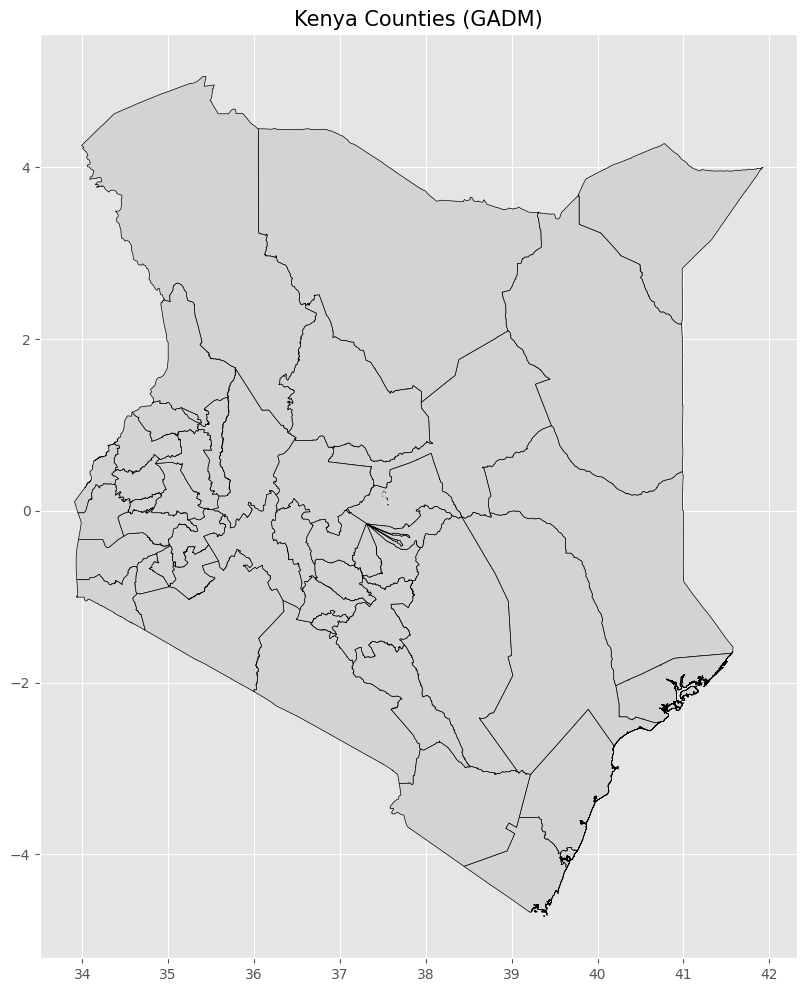

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
kenya_counties.plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.5)
plt.title("Kenya Counties (GADM)", fontsize=15)
plt.show()


**Load power stations shapefile**

In [12]:
#path to power stations shapefile
power_stations_path='/content/drive/MyDrive/mlfc_miniproject/final_mlfc/Power Stations/Power_Stations.shp'

#load power stations shapefile
power_stations=gpd.read_file(power_stations_path)

# Ensure same CRS as counties
power_stations = power_stations.to_crs(kenya_counties.crs)

#preview data
power_stations.head()


,OBJECTID,Type,Name,Capacity_M,Coordinate,X_Coord,Y_Coord,Status,Year,Remarks,geometry
0,1,Geothermal,Olkaria I Geothermal Power Station,185.0,0°53′36″S 36°18′30″E,36.308333,-0.893333,Operational,None,None,POINT (36.30833 -0.89333)
1,2,Geothermal,Olkaria II Geothermal Power Station,105.0,0°51′49″S 36°18′00″E,36.300000,-0.863611,Operational,None,None,POINT (36.3 -0.86361)
2,3,Geothermal,Olkaria III Geothermal Power Station,110.0,0°52′30″S 36°18′00″E,36.300000,-0.875000,Operational,None,None,POINT (36.3 -0.875)
3,4,Geothermal,Olkaria IV Geothermal Power Station,140.0,0°51′49″S 36°18′00″E,36.300000,-0.863611,Operational,None,None,POINT (36.3 -0.86361)
4,5,Geothermal,Olkaria V Geothermal Power Station,140.0,0°51′49″S 36°18′00″E,36.300000,-0.863611,In development,None,None,POINT (36.3 -0.86361)


In [13]:
power_stations.shape

(40, 11)

In [14]:
power_stations.keys()

Index(['OBJECTID', 'Type', 'Name', 'Capacity_M', 'Coordinate', 'X_Coord',
       'Y_Coord', 'Status', 'Year', 'Remarks', 'geometry'],
      dtype='object')

*Listing the top 5 power stations with the highest power capacity.*

In [15]:
top_5_power_stations = power_stations.sort_values(by='Capacity_M', ascending=False).head(5)
display(top_5_power_stations[['Name', 'Capacity_M', 'Type']])

,Name,Capacity_M,Type
23,Lamu Coal Power Station,960.0,Fossil fuels
28,Dongo Kundu Thermal Power Station,700.0,Fossil fuels
32,Meru Wind Power Station,400.0,Wind
30,Lake Turkana Wind Power Station,300.0,Wind
9,Gitaru Hydroelectric Power Station,225.0,Hydroelectric


***Visualizing Power Stations***

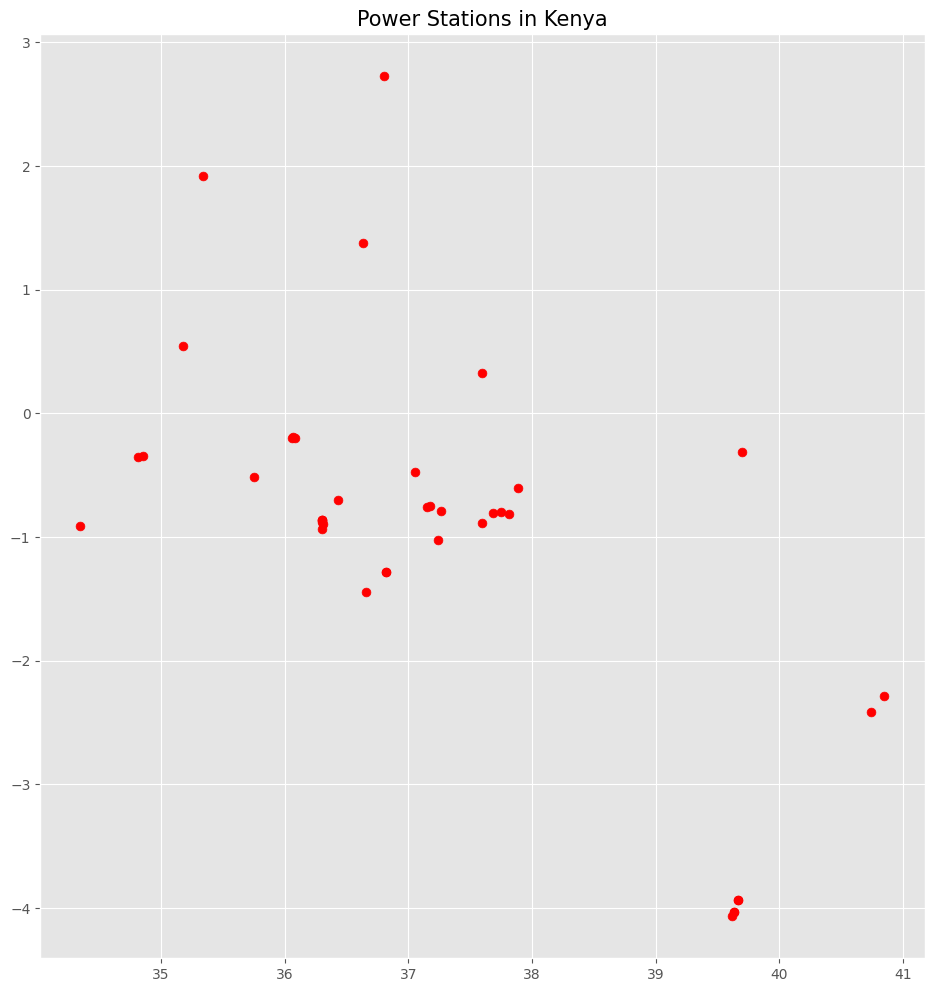

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
power_stations.plot(ax=ax, color="red", markersize=40)
plt.title("Power Stations in Kenya", fontsize=15)
plt.show()


**Visualizing Power Stations and Counties Across Kenya on One Dynamic Map**

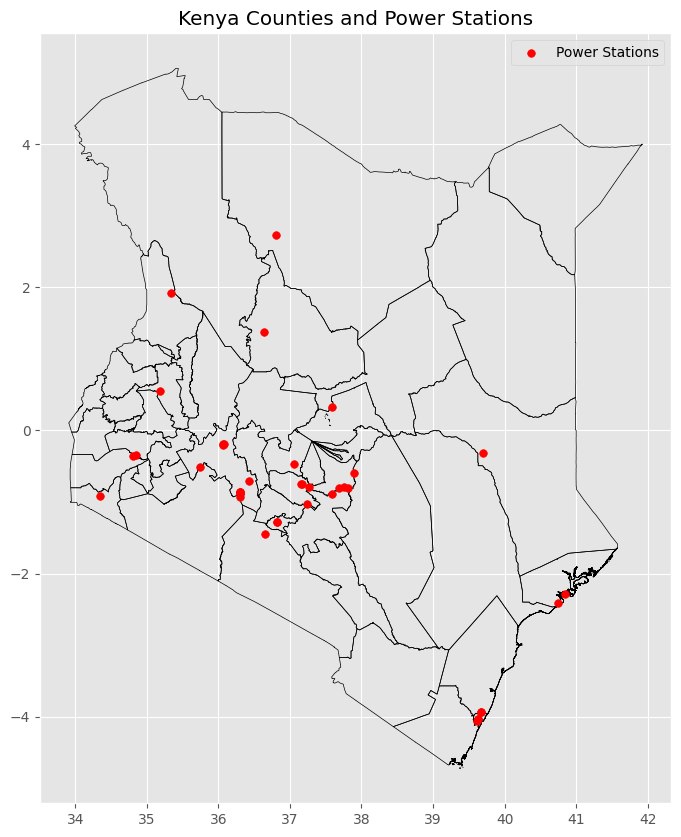

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
kenya_counties.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
power_stations.plot(ax=ax, color="red", markersize=30, label="Power Stations")
plt.legend()
plt.title("Kenya Counties and Power Stations")
plt.show()


**Power Station Count by County: An In-Depth Look at Energy Resources**

<BarContainer object of 19 artists>

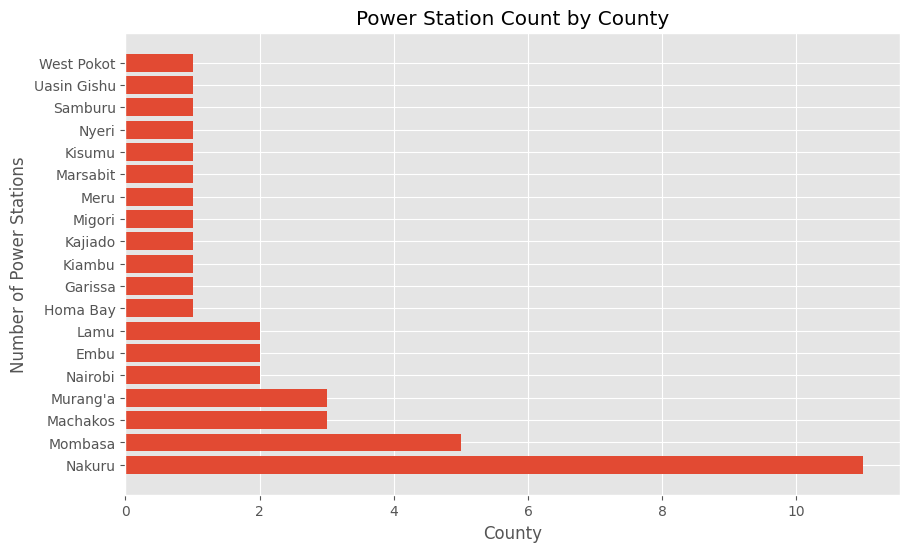

In [18]:
# Perform a spatial join to find which county each power station is in
power_stations_with_counties = gpd.sjoin(power_stations, kenya_counties, how="inner", predicate="within")

# Group by county name and count the number of power stations
power_stations_per_county = power_stations_with_counties.groupby('NAME_1').size().reset_index(name='power_station_count')

#plot bar graph
plt.figure(figsize=(10, 6))
plt.xlabel("County")
plt.ylabel("Number of Power Stations")
plt.title("Power Station Count by County")
power_stations_per_county = power_stations_per_county.sort_values(by='power_station_count', ascending=False)
plt.barh(power_stations_per_county['NAME_1'], power_stations_per_county['power_station_count'])


In [19]:
# Get the list of all county names
all_counties = kenya_counties['NAME_1'].unique()

# Get the list of counties with power stations
counties_with_stations = power_stations_per_county['NAME_1'].unique()

# Find counties without power stations
counties_without_stations = [county for county in all_counties if county not in counties_with_stations]

# Display the result
print("Counties without a single power station:")
for county in counties_without_stations:
    print(county)

Counties without a single power station:
Baringo
Bomet
Bungoma
Busia
Elgeyo-Marakwet
Isiolo
Kakamega
Kericho
Kilifi
Kirinyaga
Kisii
Kitui
Kwale
Laikipia
Makueni
Mandera
Nandi
Narok
Nyamira
Nyandarua
Siaya
Taita Taveta
Tana River
Tharaka-Nithi
Trans Nzoia
Turkana
Vihiga
Wajir


Total Power Stations Capacity in Kenya: 4818.80 MW


<BarContainer object of 19 artists>

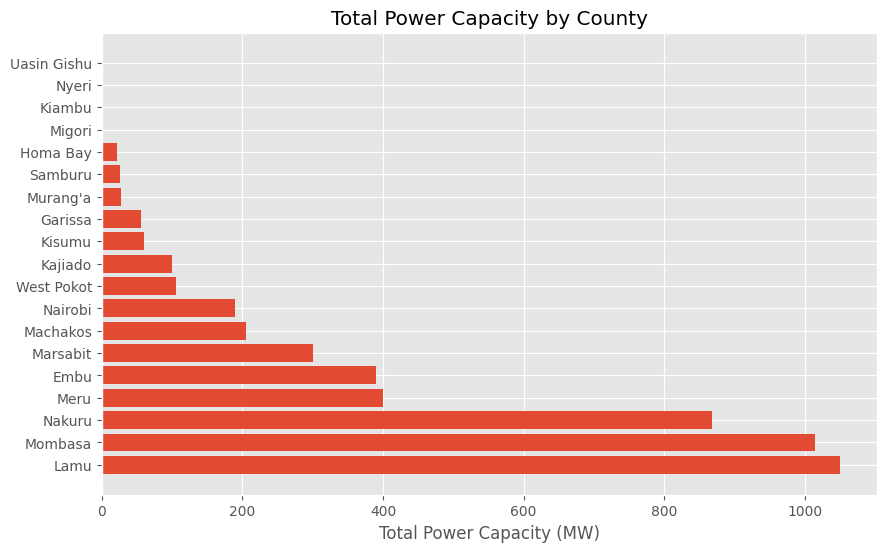

In [20]:
# Calculate total capacity for the entire country
total_capacity_country = power_stations['Capacity_M'].sum()
print(f"Total Power Stations Capacity in Kenya: {total_capacity_country:.2f} MW")

# Calculate total capacity per county
power_stations_capacity_per_county = power_stations_with_counties.groupby('NAME_1')['Capacity_M'].sum().reset_index(name='total_capacity_MW')

#Plot power stations capacity
plt.figure(figsize=(10, 6))
plt.xlabel("Total Power Capacity (MW)")
plt.title("Total Power Capacity by County")
power_stations_capacity_per_county = power_stations_capacity_per_county.sort_values(by='total_capacity_MW', ascending=False)
plt.barh(power_stations_capacity_per_county['NAME_1'], power_stations_capacity_per_county['total_capacity_MW'])
# Display the total capacity per county, sorted by capacity
#display(power_stations_capacity_per_county.sort_values(by='total_capacity_MW', ascending=False))

**Analyze Power Capacity by Type**

([<matplotlib.patches.Wedge at 0x7fd2b06f0f20>,
 [Text(-0.8259600868426968, -0.7264915243434055, 'Fossil fuels'),
  Text(1.011541358467224, -0.4321852381910835, 'Wind'),
  Text(0.8044903409281301, 0.7501968350728636, 'Geothermal'),
  Text(-0.29237503999433245, 1.0604323816200223, 'Hydroelectric'),
  Text(-0.8167593645674631, 0.7368202904313602, 'Solar')],
 [Text(-0.45052368373238005, -0.396268104187312, '45.2%'),
  Text(0.551749831891213, -0.23573740264968188, '19.0%'),
  Text(0.43881291323352545, 0.4091982736761074, '17.7%'),
  Text(-0.15947729454236312, 0.5784176627018303, '16.9%'),
  Text(-0.44550510794588893, 0.4019019765989237, '1.1%')])

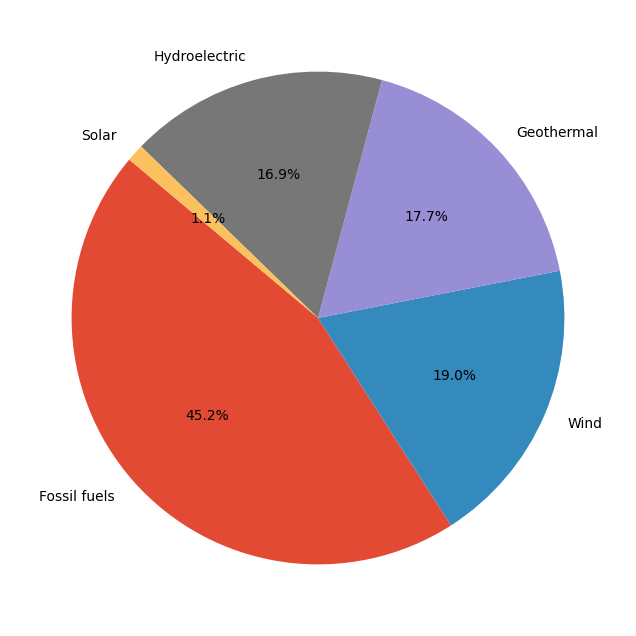

In [21]:
# Calculate total capacity per power station type
capacity_by_type = power_stations.groupby('Type')['Capacity_M'].sum().reset_index(name='total_capacity_MW')

# Sort by total capacity in descending order
capacity_by_type_sorted = capacity_by_type.sort_values(by='total_capacity_MW', ascending=False)

#plot a piechart
plt.figure(figsize=(8, 8))
plt.pie(capacity_by_type_sorted['total_capacity_MW'], labels=capacity_by_type_sorted['Type'], autopct='%1.1f%%', startangle=140)

# Display the result
#display(capacity_by_type_sorted)

**Visualize Power Capacity by Type**

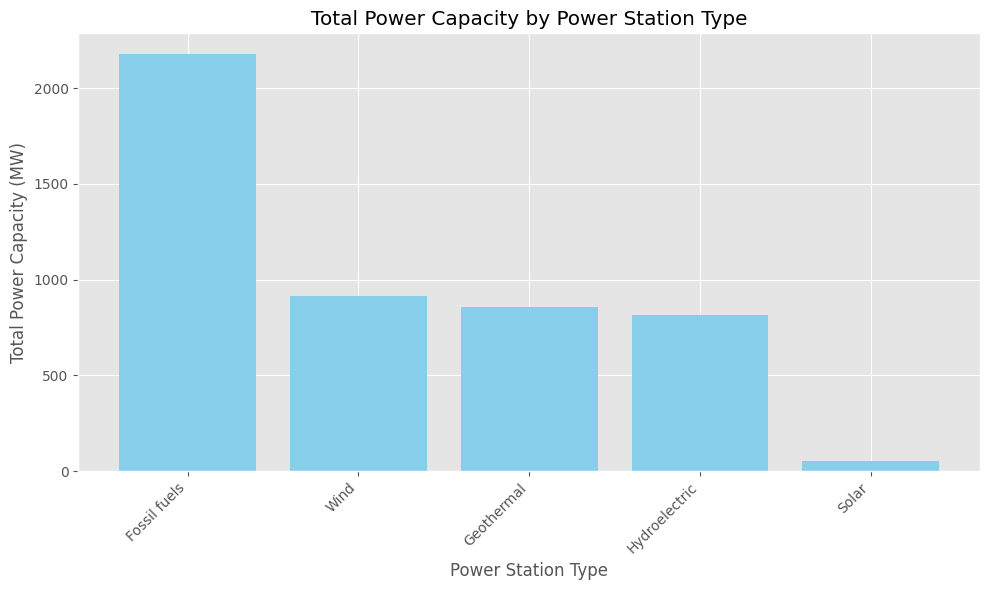

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(capacity_by_type_sorted['Type'], capacity_by_type_sorted['total_capacity_MW'], color='skyblue')
plt.xlabel("Power Station Type")
plt.ylabel("Total Power Capacity (MW)")
plt.title("Total Power Capacity by Power Station Type")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

**Spatial Analysis of Capacity: Choropleth Map**

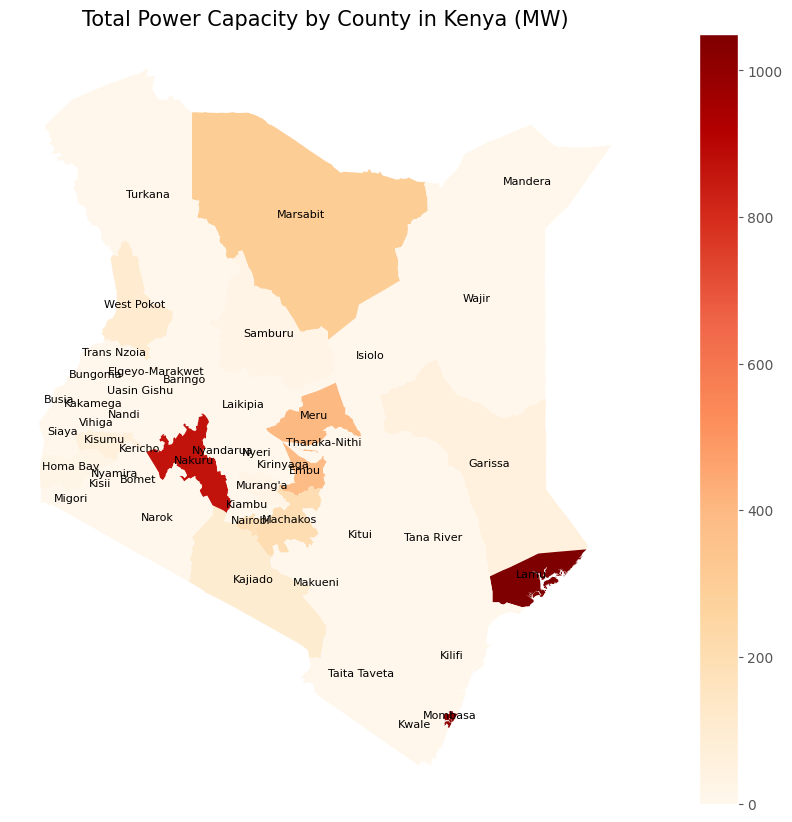

In [23]:
# Merge county geometries with the power station capacity data
kenya_counties_capacity = kenya_counties.merge(power_stations_capacity_per_county, left_on='NAME_1', right_on='NAME_1', how='left')

# Fill counties with no power stations with 0 capacity
kenya_counties_capacity['total_capacity_MW'] = kenya_counties_capacity['total_capacity_MW'].fillna(0)

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
kenya_counties_capacity.plot(column='total_capacity_MW', ax=ax, legend=True,
                             cmap='OrRd',  # Color map (e.g., Orange to Red)
                             missing_kwds={'color': 'lightgrey', 'edgecolor': 'black', 'label': 'No data'})

# Add county names as labels (optional, can be crowded)
for idx, row in kenya_counties_capacity.iterrows():
    ax.annotate(text=row['NAME_1'], xy=row['geometry'].centroid.coords[0],
                horizontalalignment='center', fontsize=8)

plt.title('Total Power Capacity by County in Kenya (MW)', fontsize=15)
ax.set_axis_off() # Turn off axis
plt.show()

**Analyze Power Station Status**

([<matplotlib.patches.Wedge at 0x7fd2b0506120>,
 [Text(-0.3307765530310109, -1.0490885910946335, 'Commissioned'),
  Text(1.0125556260429365, 0.42980356463016567, 'In development'),
  Text(0.49081749951093007, 0.9844278450825323, 'Operational'),
  Text(-0.3490350588855837, 1.0431560418598635, 'Planned'),
  Text(-0.7845748600804942, 0.7710008358813064, 'Under construction')],
 [Text(-0.18042357438055137, -0.5722301405970727, '62.5%'),
  Text(0.5523030687506926, 0.23443830798009033, '10.0%'),
  Text(0.2677186360968709, 0.5369606427722903, '12.5%'),
  Text(-0.19038275939213656, 0.5689942046508346, '12.5%'),
  Text(-0.42794992368026946, 0.42054591048071255, '2.5%')])

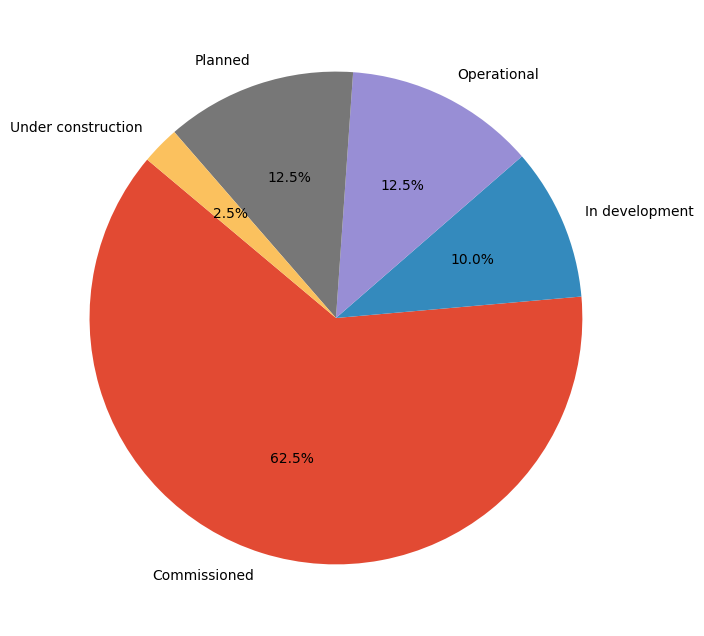

In [24]:
# Group by status and calculate the count and sum of capacity
status_analysis = power_stations.groupby('Status').agg(
    station_count=('OBJECTID', 'count'),
    total_capacity_MW=('Capacity_M', 'sum')
).reset_index()

#Plot status in a piechart
plt.figure(figsize=(8, 8))
plt.pie(status_analysis['station_count'], labels=status_analysis['Status'], autopct='%1.1f%%', startangle=140)

# Display the result
#display(status_analysis)

## **2. Querying OSM Features**

**OSM layers**

We now extract environmental features from OpenStreetMap that might influence power station locations (e.g., rivers, forests, highways). We define a dictionary of OSM tags of interest. Each key is an OSM feature type, and its value is a list of feature values to query. For example:

```"waterway": ["river"]``` (fetch** **rivers)

```"natural": ["water", "lake", "reservoir"]``` (water bodies)

```"landuse": ["forest"] ```(vegetation)

```"power": ["tower", "substation"]``` (power infrastructure)

```"boundary": ["protected_area", "national_park"]``` (protected areas).

In [25]:
import osmnx as ox

# Define tags for environmental features potentially impacted by power stations
tags = {
    "waterway": ["river", "dam"],
    "natural": ["water", "lake", "reservoir"],
    "landuse": ["forest"],
    "power": ["tower", "substation"],
    "boundary": ["protected_area", "national_park"]
}

Next, we determine a bounding box that covers all of Kenya, which is needed by OSMnx. We extract the total bounds of the counties GeoDataFrame (north, west, south, east) and create the bbox tuple:

In [26]:
north,west,south, east = kenya_counties.total_bounds
bbox = (north,west,south, east)  # for OSMnx


With the tags and bbox defined, we call a custom function from the ```fynesse``` package to fetch all these features per county. The function ```plot_osm_features_by_county(kenya_counties, tags, save_csv=True)```  queries OSM for the specified tags in each county polygon and saves the results as CSV files (one per county). The  ```save_csv=True``` option ensures we save these intermediate results for later reuse.

This step may take several minutes as it hits the OSM API for each feature type. The output will be a directory of CSV files (e.g., ```county_pois_csv/Baringo.csv```, etc.), each listing all matched points (points of interest) for that county.

bbox (35.52291870000016, -0.19890102799985243, 36.49006652800011, 1.6607313160000103)


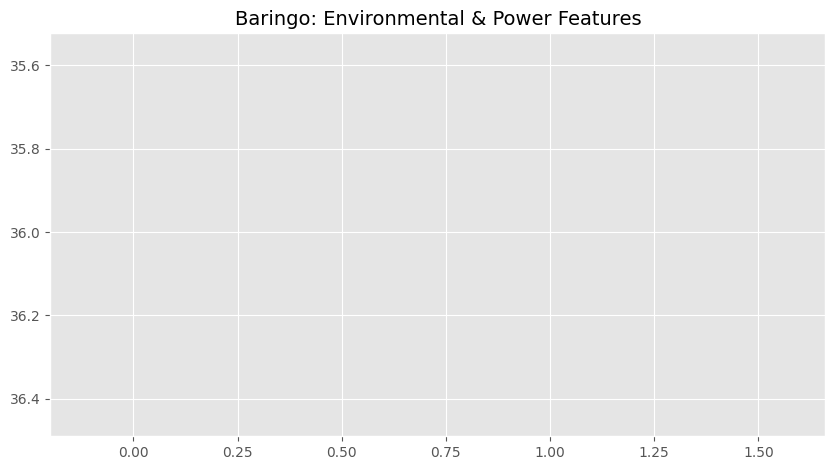

bbox (35.01186370800019, -1.0311536789998286, 35.58723449700017, -0.39513552299990806)


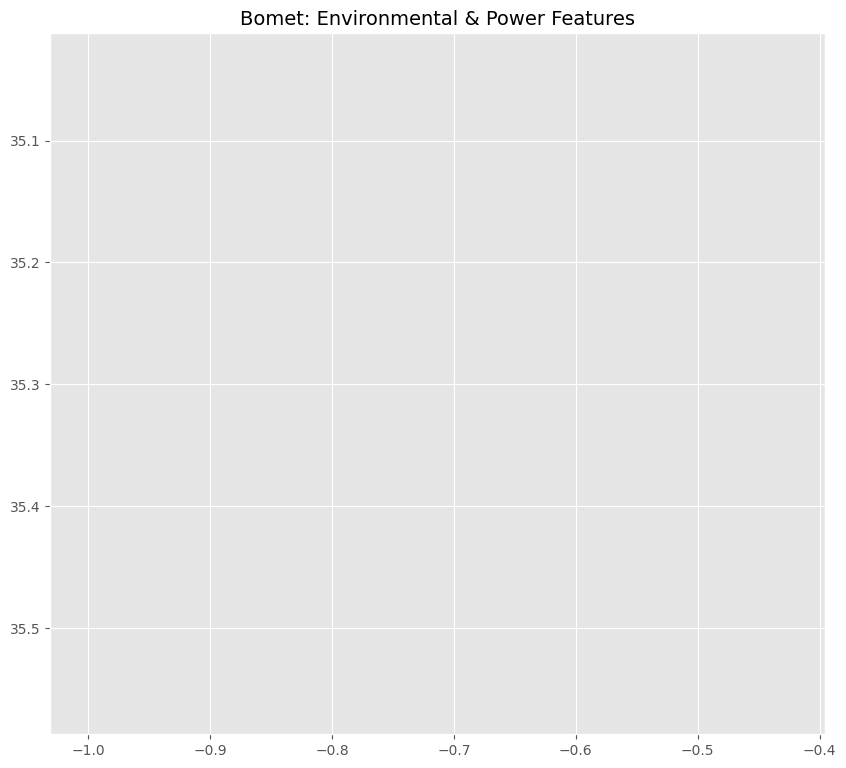

bbox (34.363464356000065, 0.4251880350001329, 35.15554809499997, 1.1512399920001712)


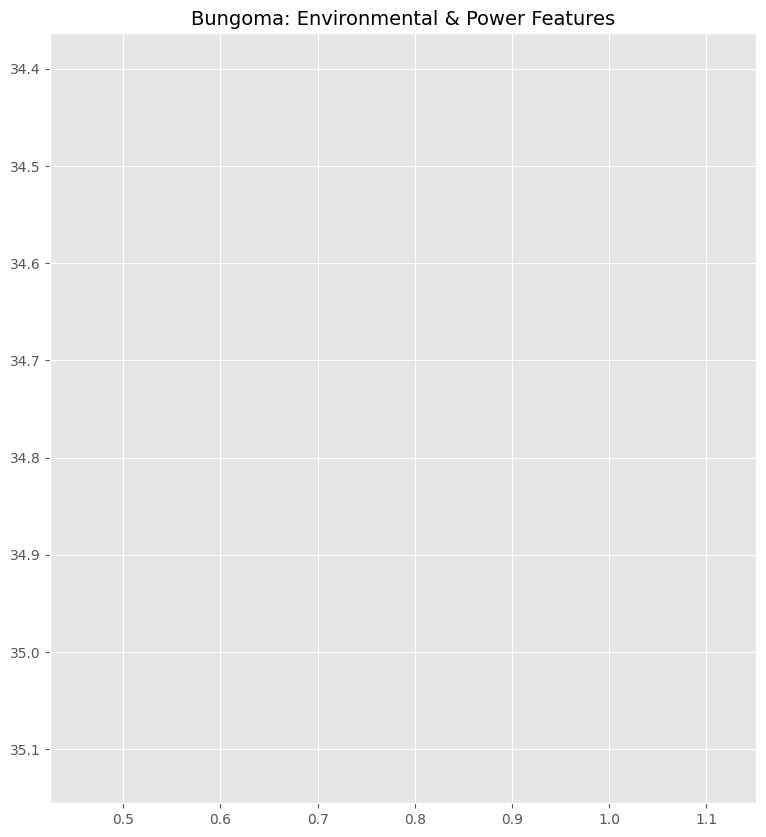

bbox (33.9095880000001, -0.023871196999834865, 34.43462371800007, 0.7802008400001341)


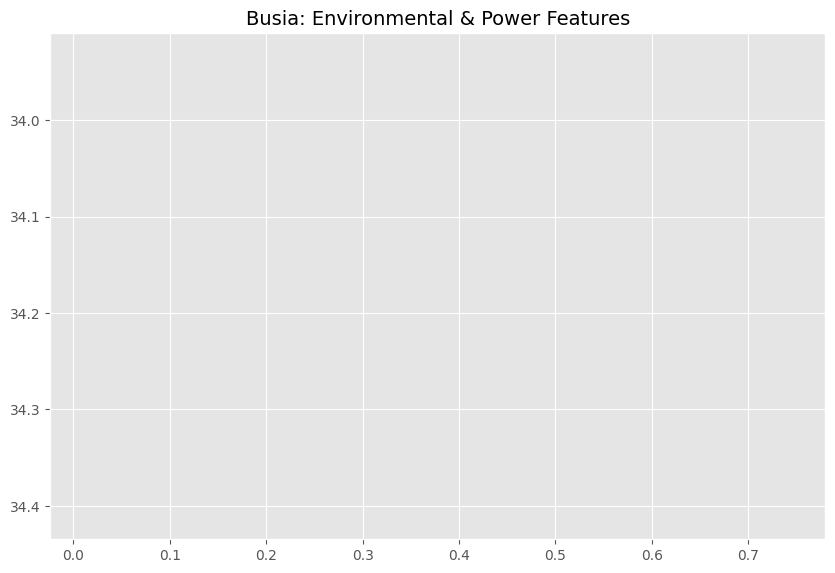

bbox (35.151699065, 0.17438377500008073, 35.72312927200005, 1.32406509000009)


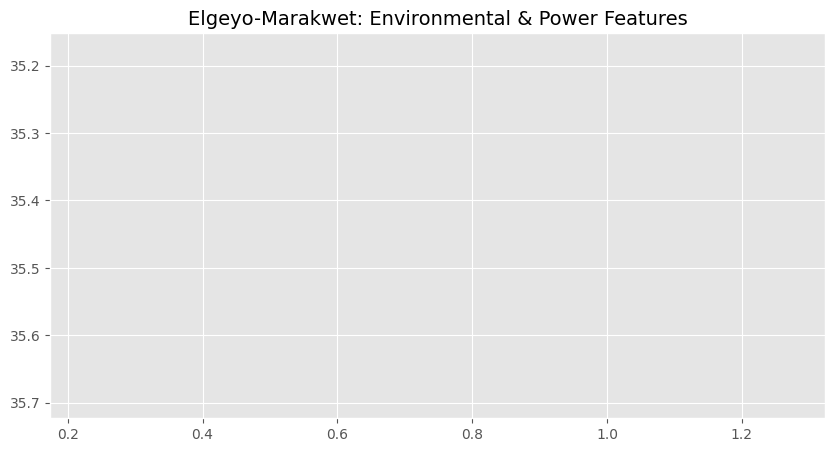

bbox (37.26687240600012, -0.9161317339999755, 37.93591308599997, -0.1458601449999719)


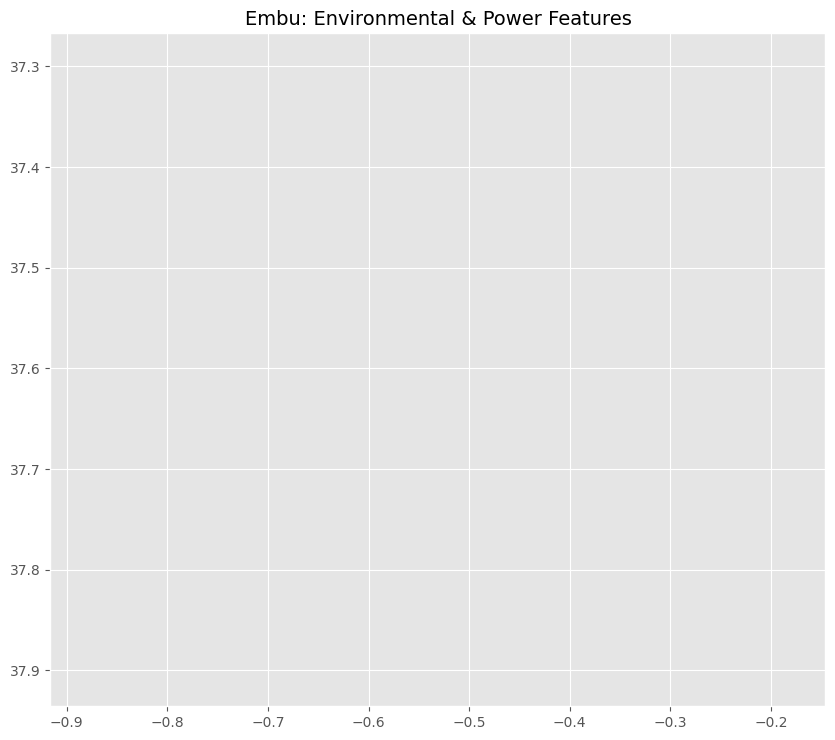

bbox (38.65771484400011, -2.0397276869999246, 41.57735800000006, 0.9948730470001124)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 43 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


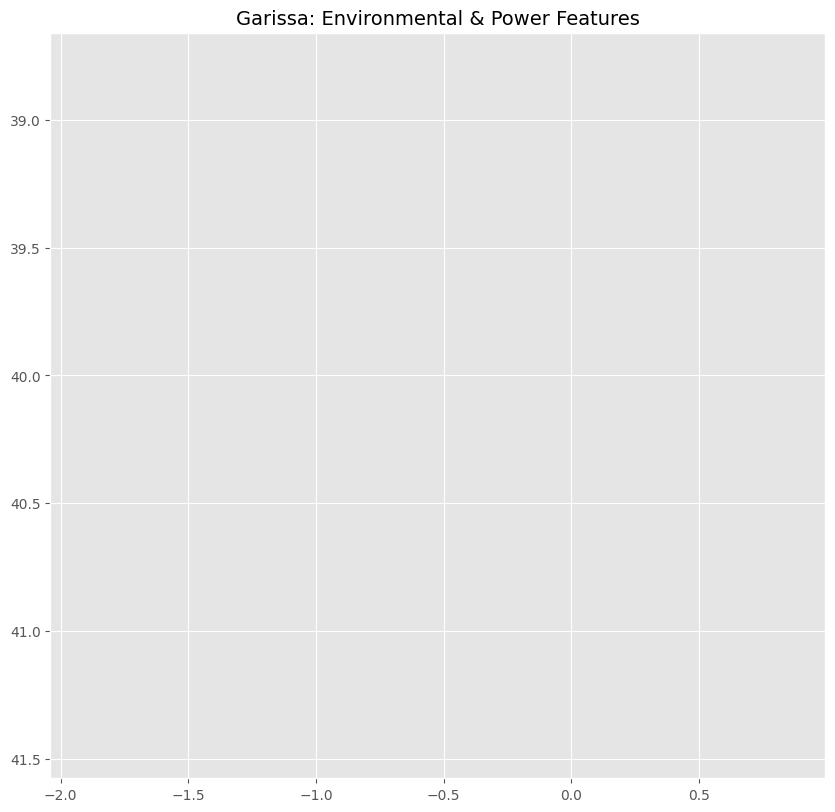

bbox (33.928565999000114, -0.8620423069998537, 35.02160263100018, -0.2527543309999487)


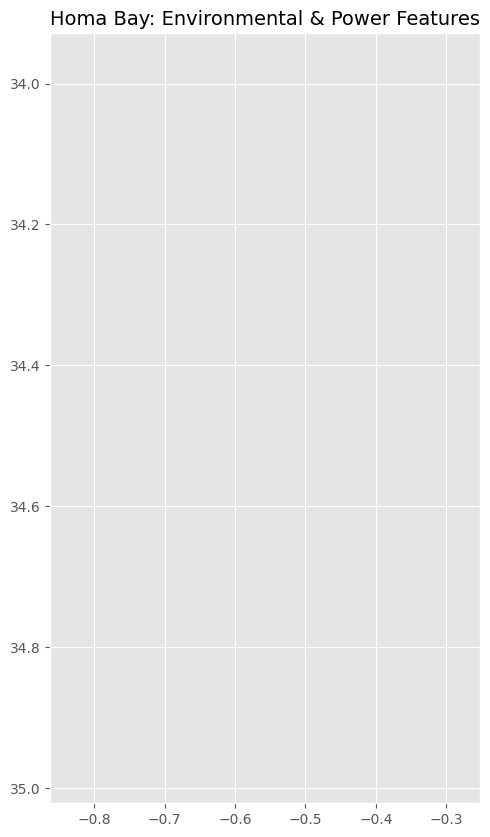

bbox (36.86450195300006, -0.08642578199993523, 39.462482453000064, 2.099836112000105)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 27 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


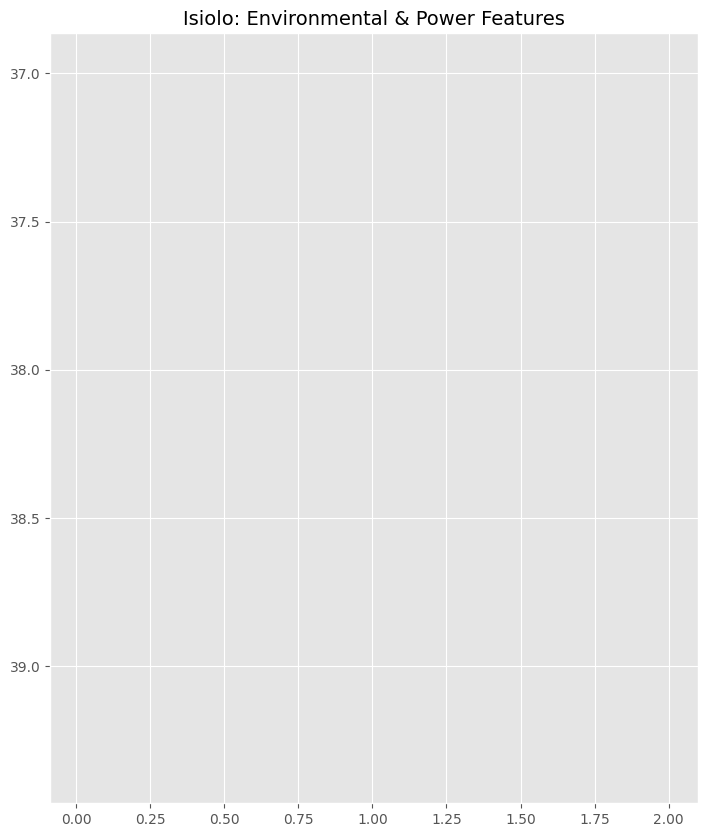

bbox (35.99620056100014, -3.1870117179998942, 37.937458039000035, -1.0407847169998945)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 20 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


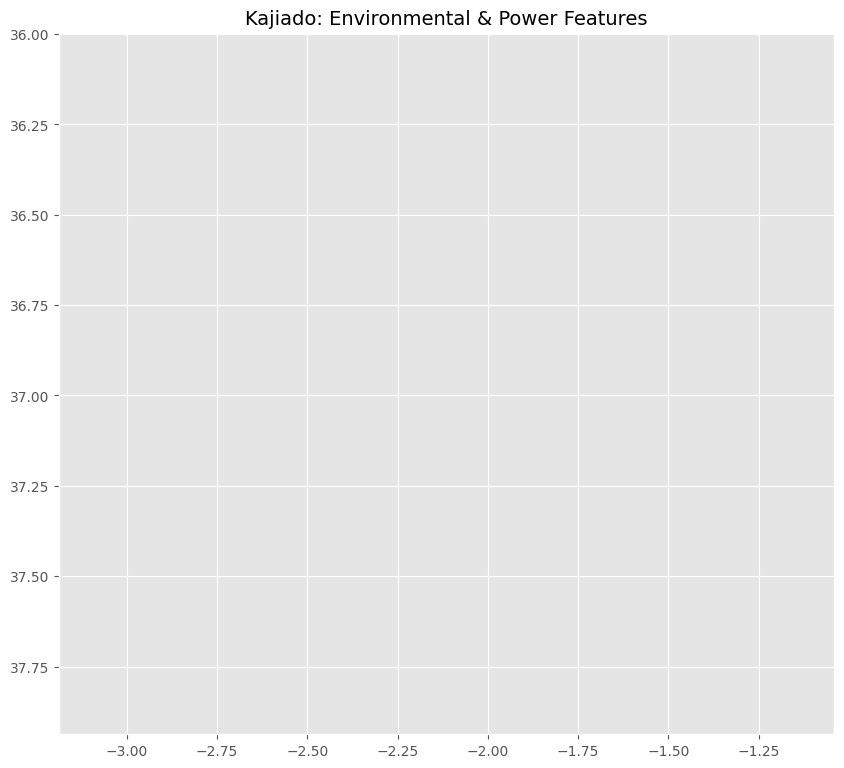

bbox (34.343139649000136, 0.09328348899998673, 34.97848129300007, 0.6557419300000333)


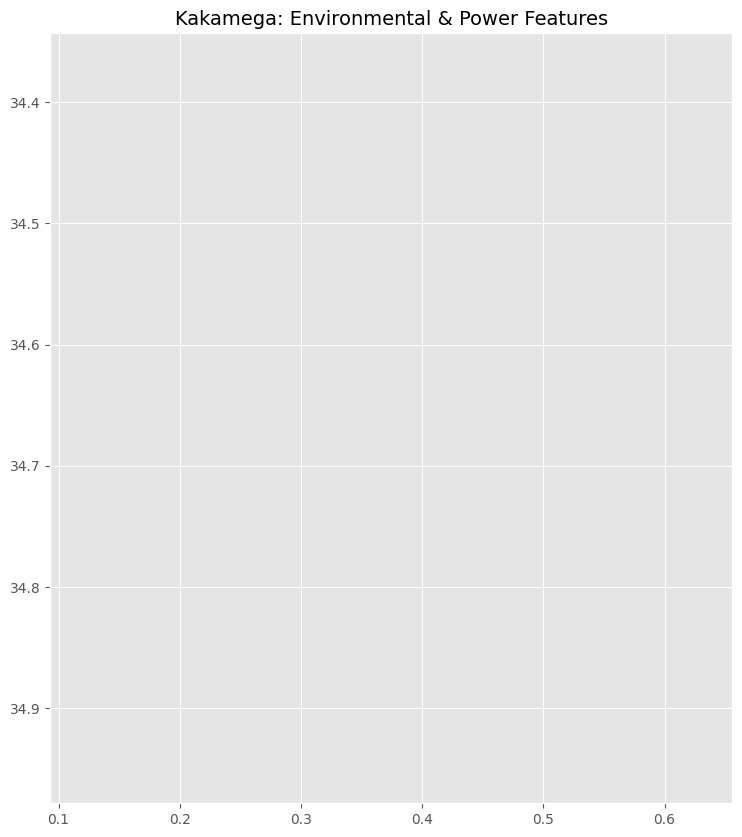

bbox (35.00396347000003, -0.6580803389999801, 35.67504119900019, 0.0318928890000052)


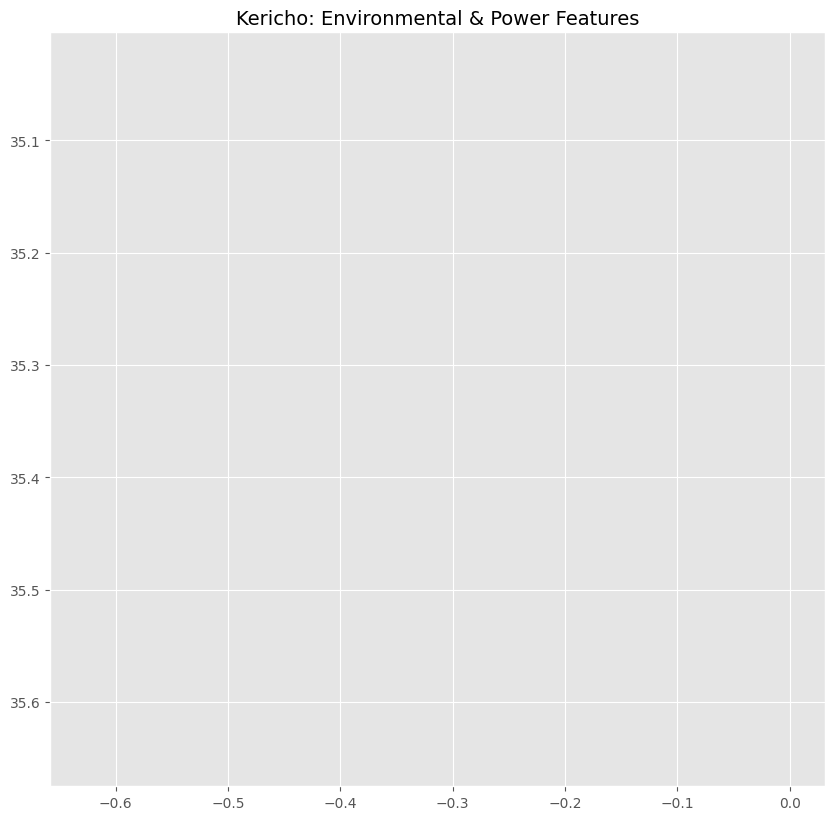

bbox (36.49081421000017, -1.3078428509998616, 37.42107391400009, -0.7526243919999729)


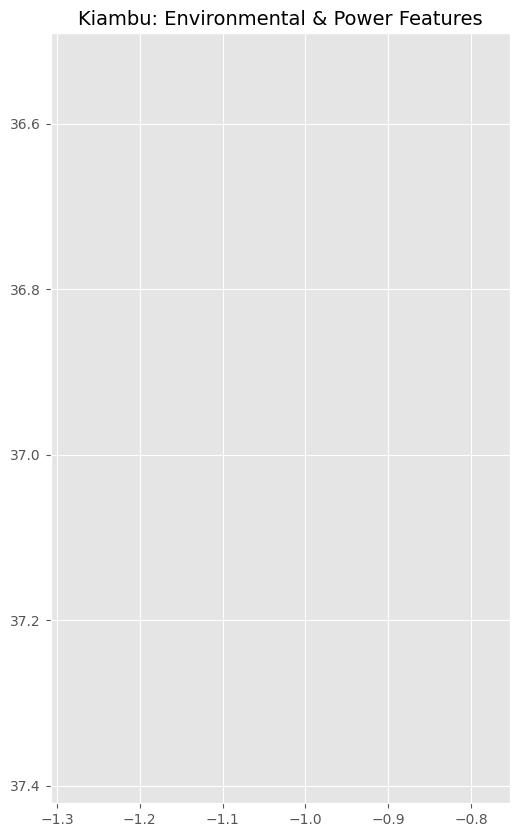

bbox (39.08728027300003, -3.9913587569999436, 40.24152800000019, -2.3092041019998533)


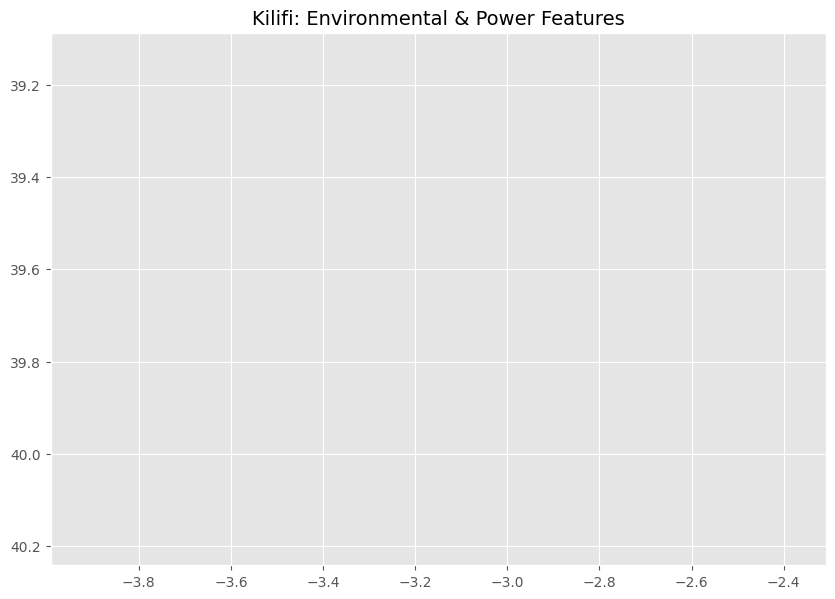

bbox (37.14381027200017, -0.7852180649999241, 37.73555710400012, 0.23309299900006408)


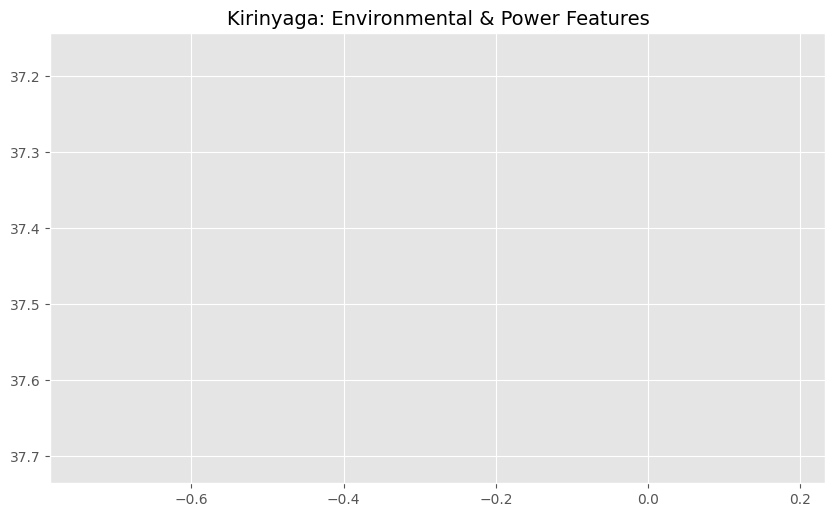

bbox (34.60992813100006, -0.9673585889998435, 35.012722015000065, -0.4969400449999739)


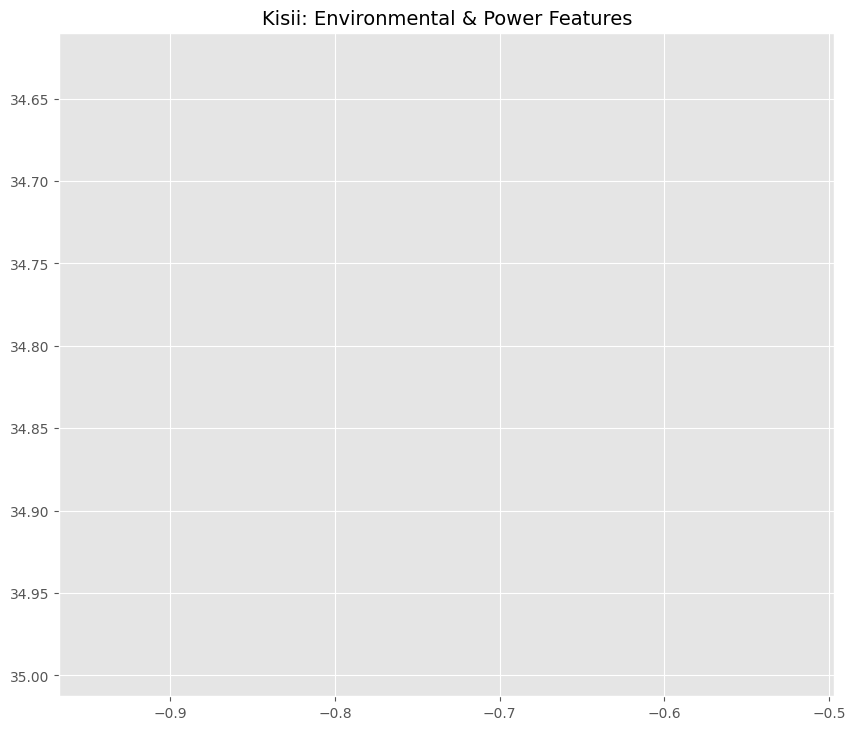

bbox (34.41506576500018, -0.4103384019999794, 35.34301757800006, 0.030121457000177543)


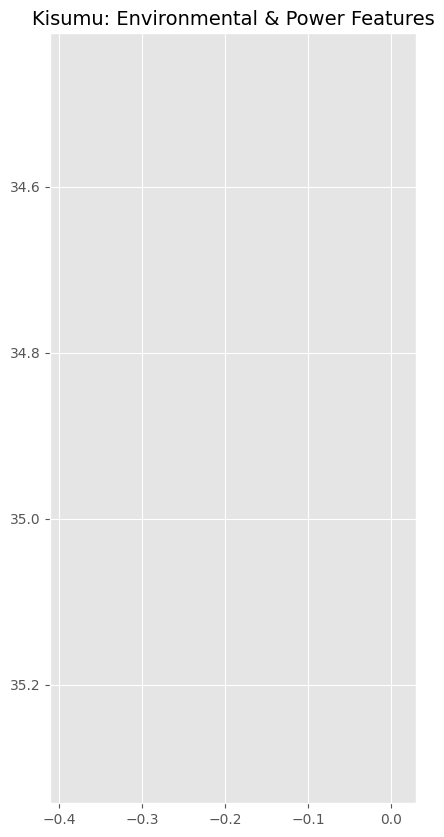

bbox (37.595703124000124, -3.0684576029998993, 39.07612228300019, -0.05186278399992261)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 21 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


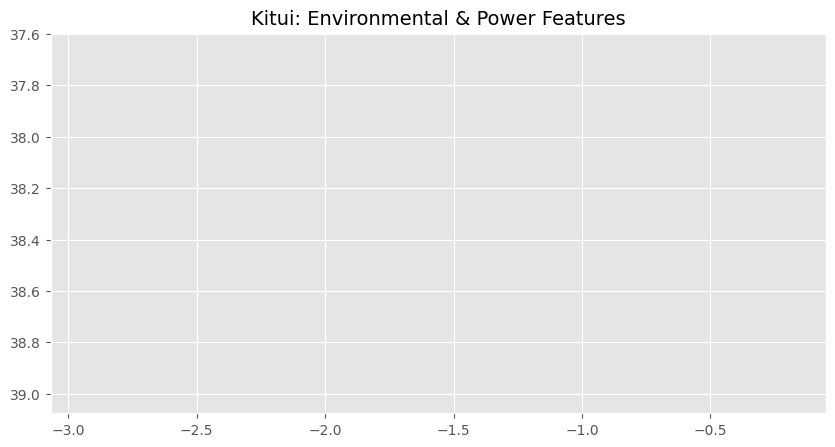

bbox (38.44500732400007, -4.72041700099993, 39.64458465600012, -3.5645141599999306)


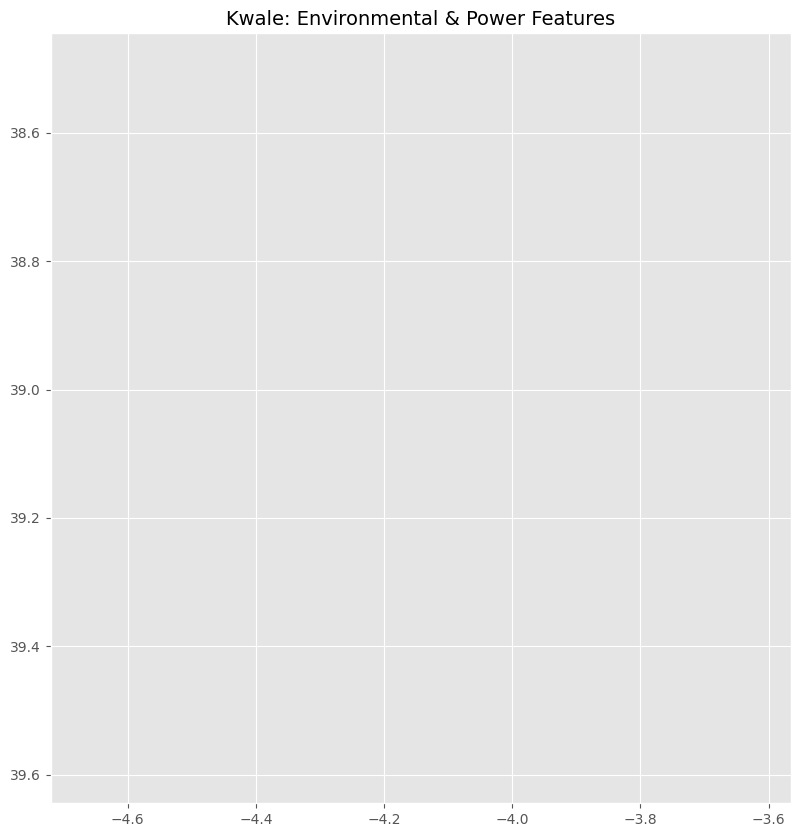

bbox (36.225673676000156, -0.28927764299987757, 37.395648957000105, 0.8754774320000251)


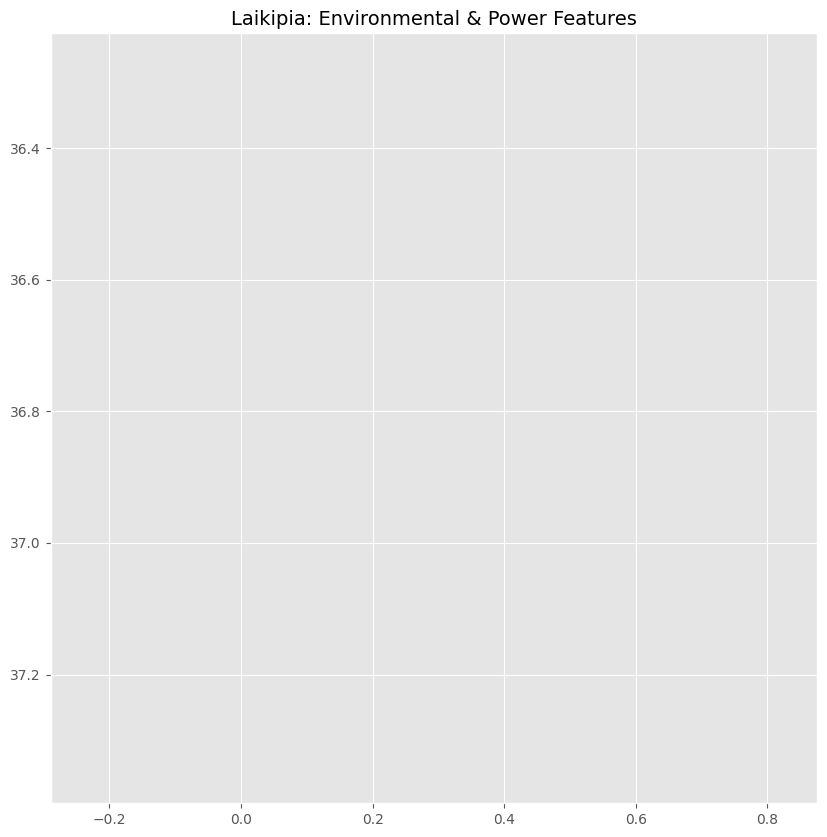

bbox (40.21270752000015, -2.5462490009999215, 41.56236300000012, -1.6580226409998886)


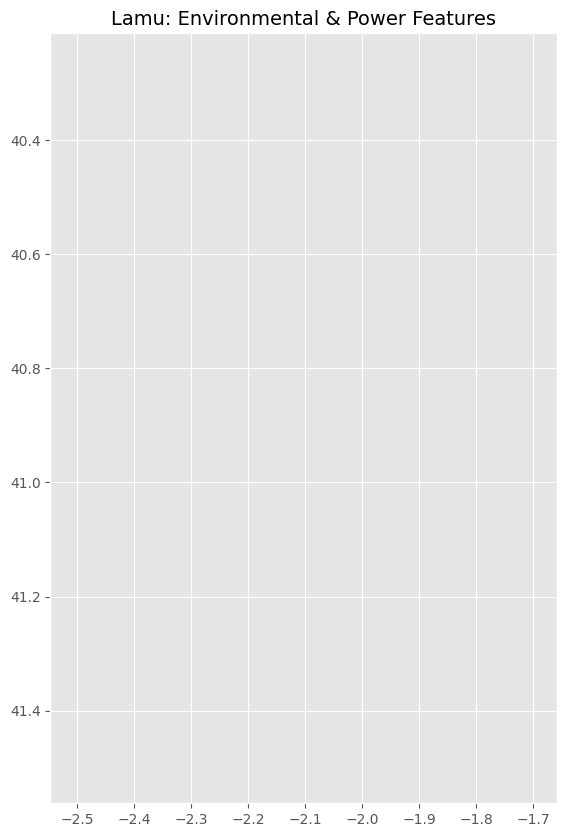

bbox (36.87829589900002, -1.7778223749999142, 37.86812973000008, -0.7744643679998262)


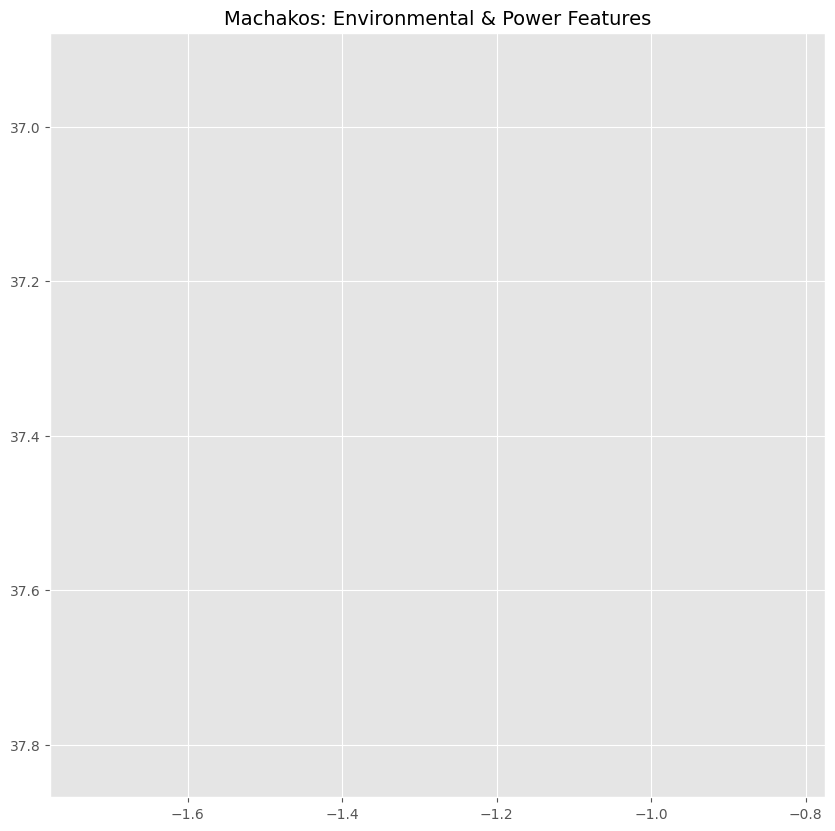

bbox (37.14128875800009, -2.9922132499999634, 38.51941680900018, -1.5151672369999574)


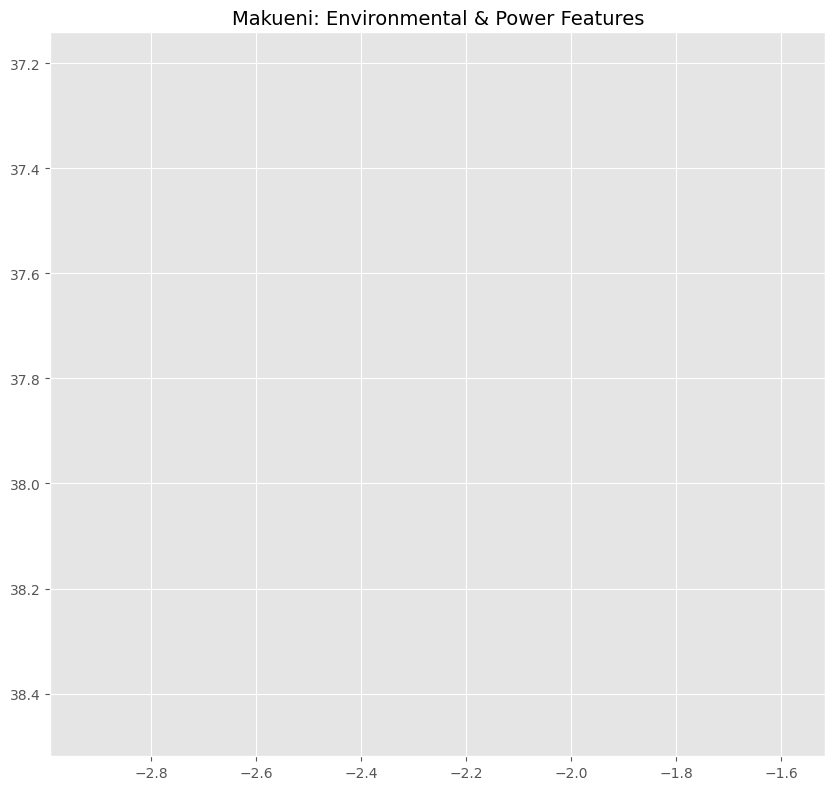

bbox (39.77924346900011, 2.176086425000051, 41.926216126000156, 4.277197837000074)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 22 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


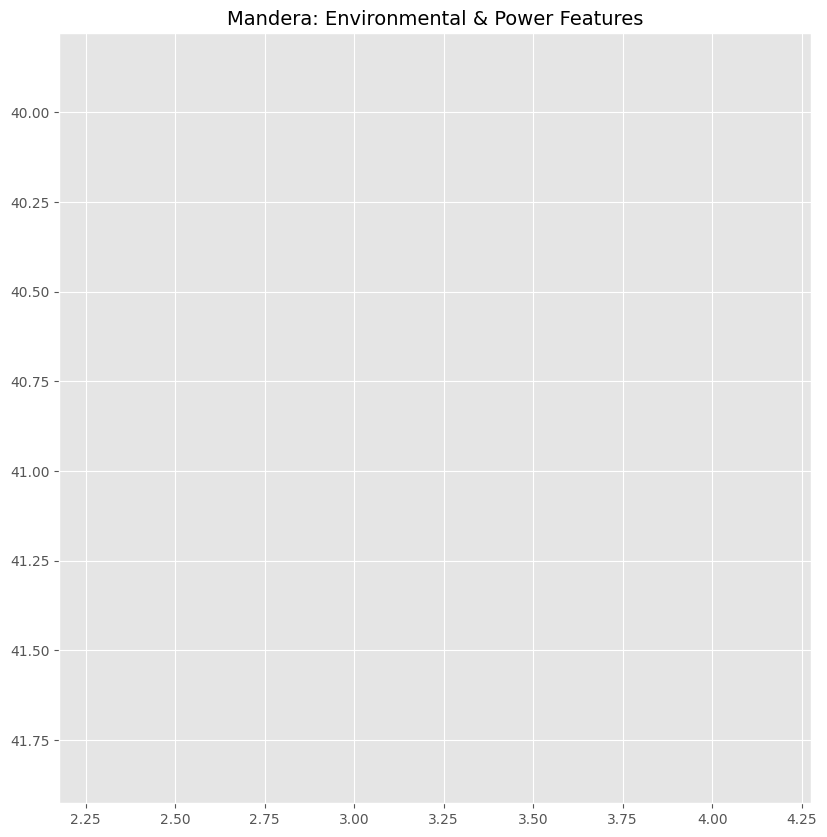

bbox (36.04948425200001, 1.263595462000069, 39.345886231000065, 4.454700946999992)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


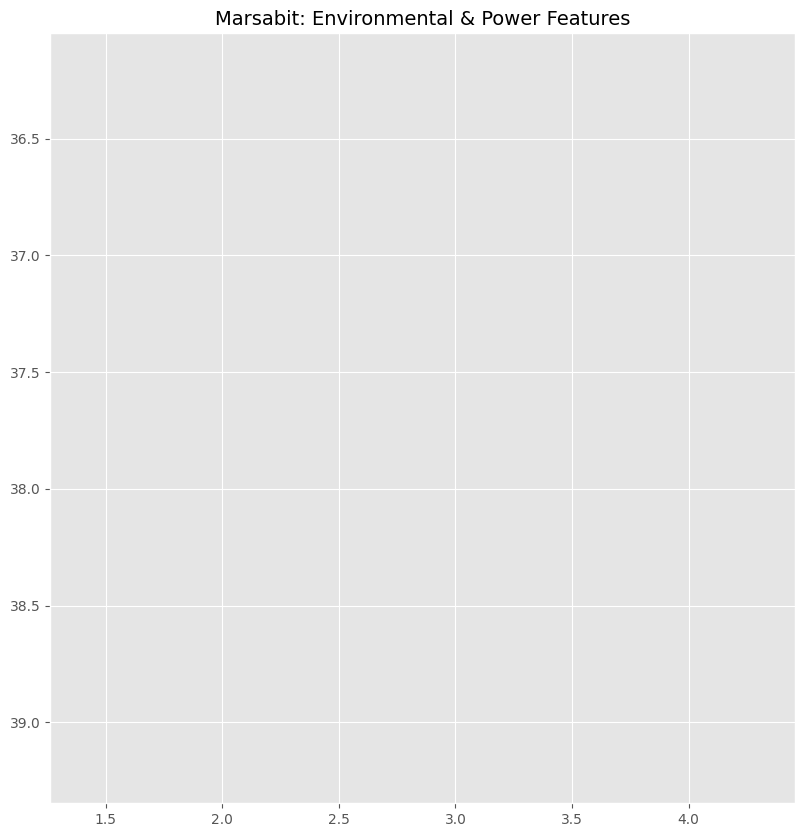

bbox (37.087646485000164, -0.2130126959999643, 38.41931152300003, 0.6710815440000601)


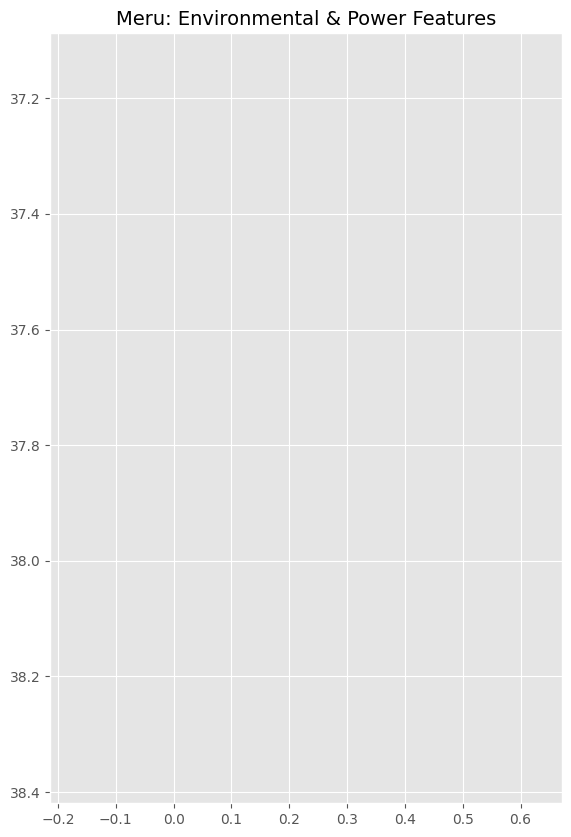

bbox (33.93090438899998, -1.3901921499999048, 34.732467650000046, -0.6451439269999355)


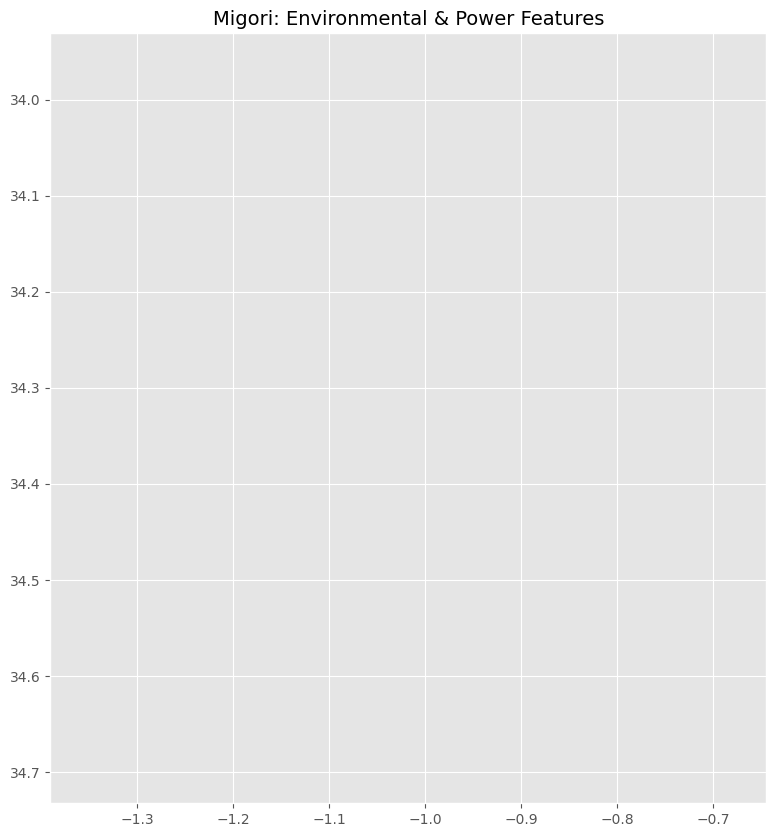

bbox (39.56417499999998, -4.15307569499987, 39.764026643000136, -3.91827399999994)


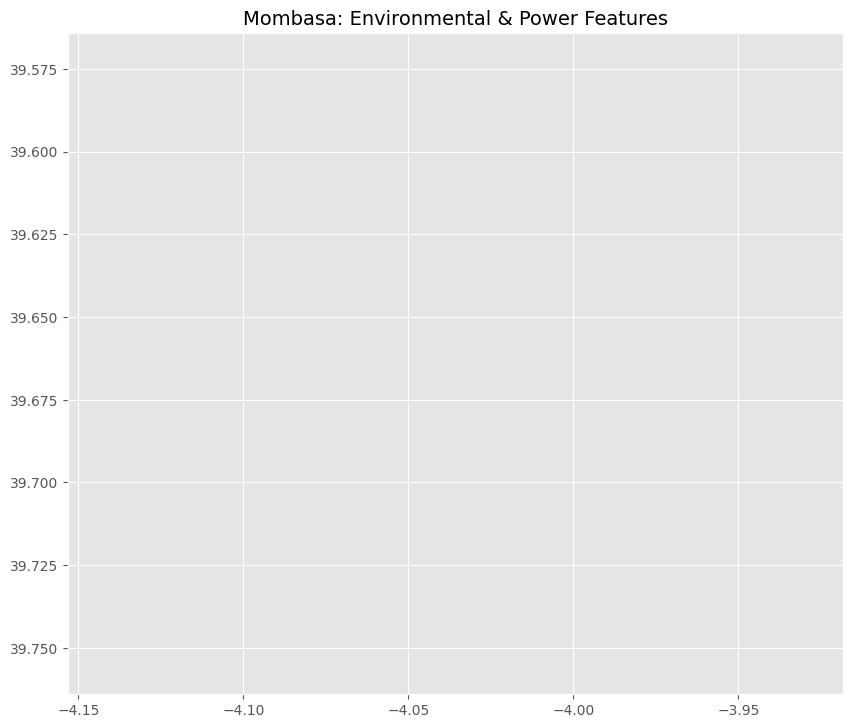

bbox (36.705768585000044, -1.0893596409999304, 37.42107391400009, -0.5603811149998705)


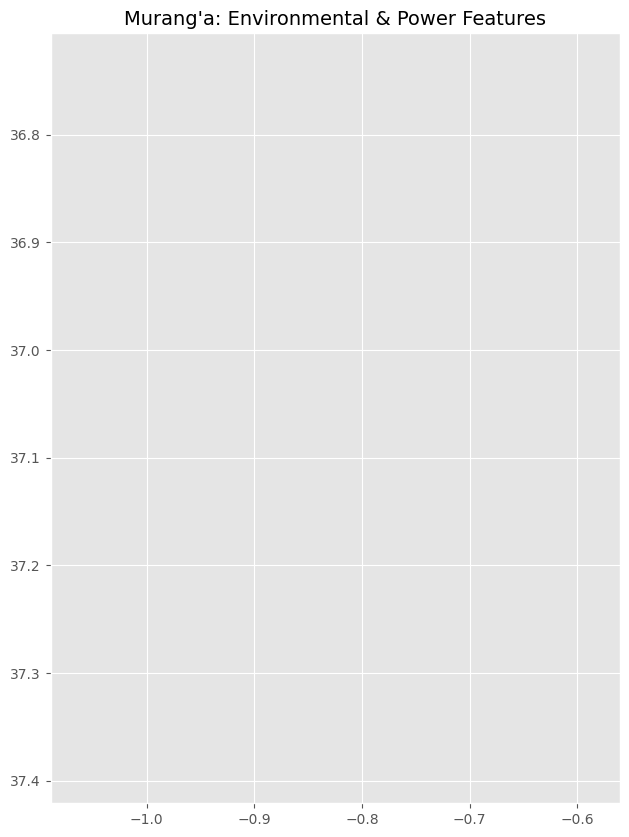

bbox (36.66347503600019, -1.4421585799999548, 37.10370254500015, -1.1579102279999347)


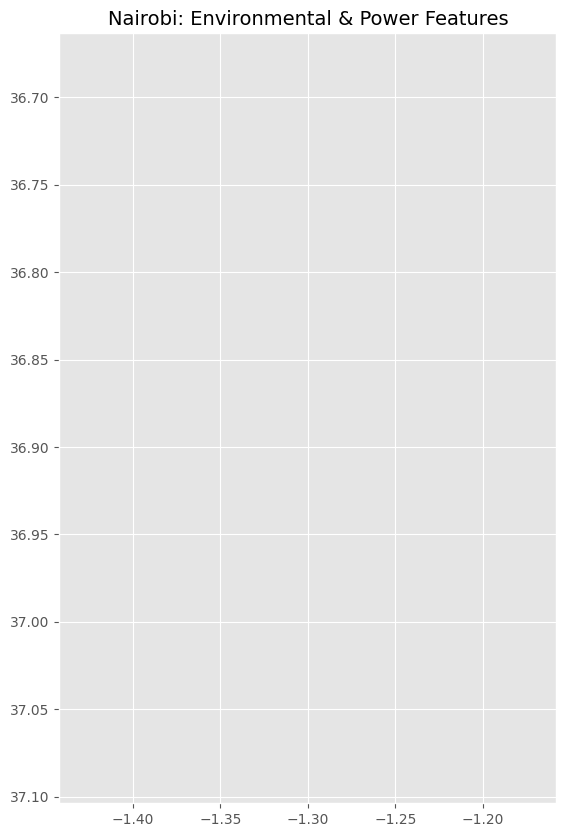

bbox (35.413902282000095, -1.1488211149999756, 36.60010528600003, 0.2400074610000047)


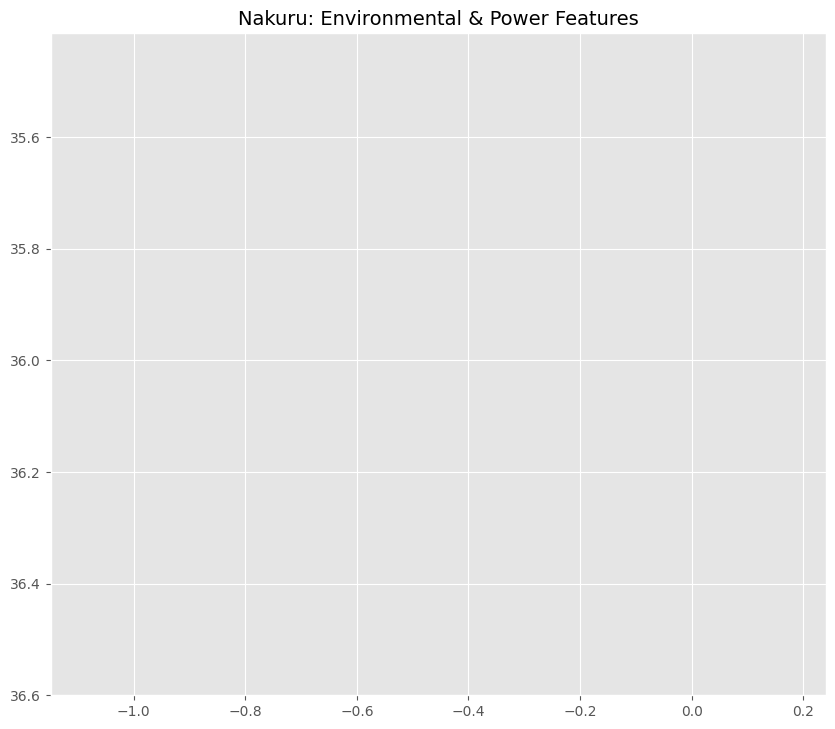

bbox (34.739463806000174, -0.10327247599991551, 35.43819427500017, 0.5672197940001524)


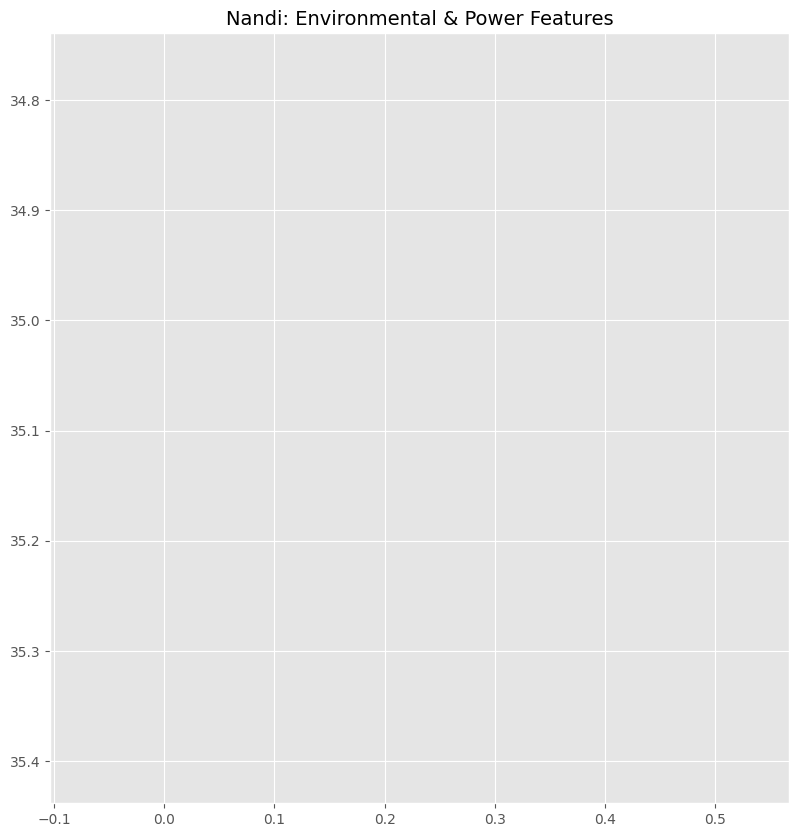

bbox (34.59016418400017, -2.1025750639998364, 36.34778213500016, -0.45008039499992947)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 14 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


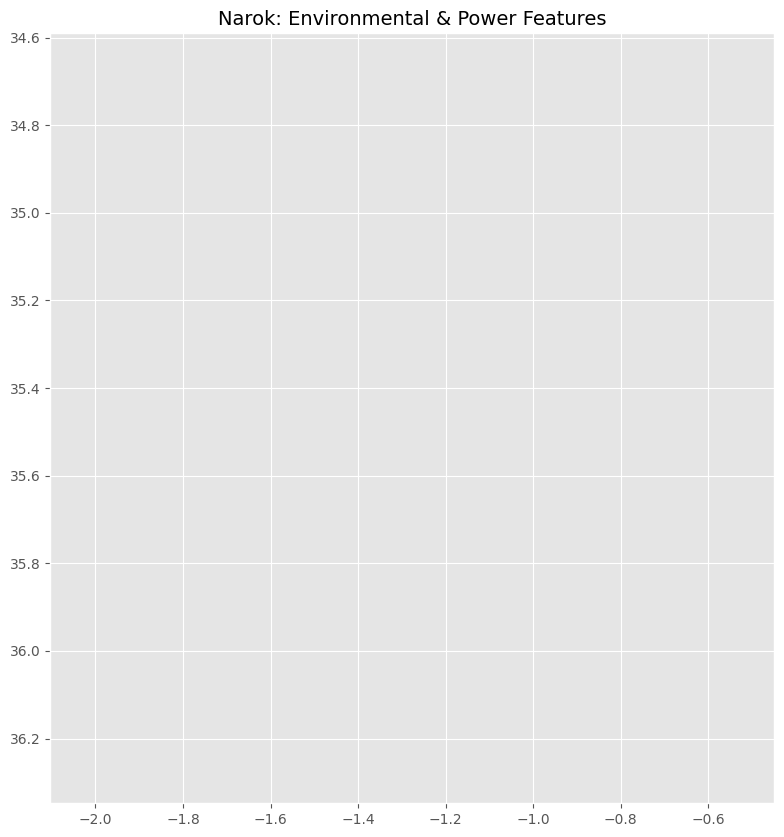

bbox (34.77786636300016, -0.8839003449999723, 35.091304780000144, -0.40651926399982585)


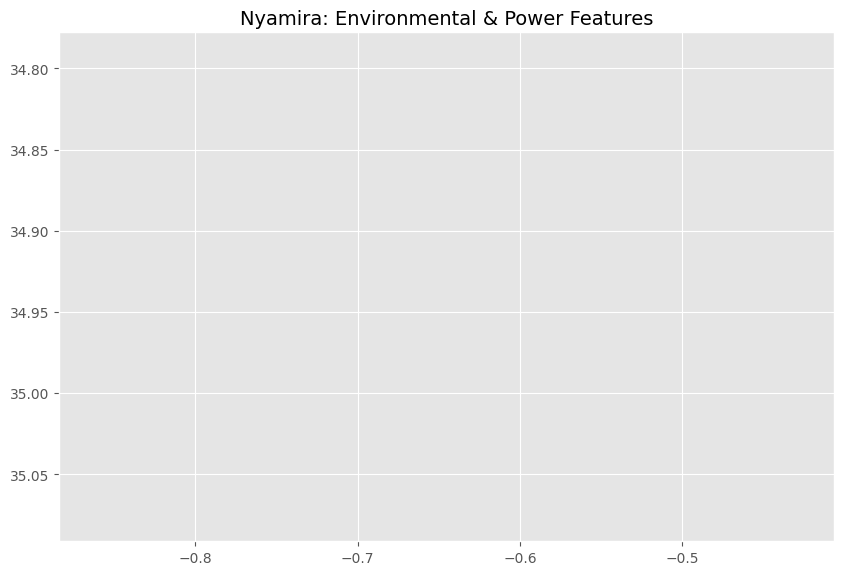

bbox (36.20078659000012, -0.9146212939999714, 36.73668289100016, 0.14424401600007286)


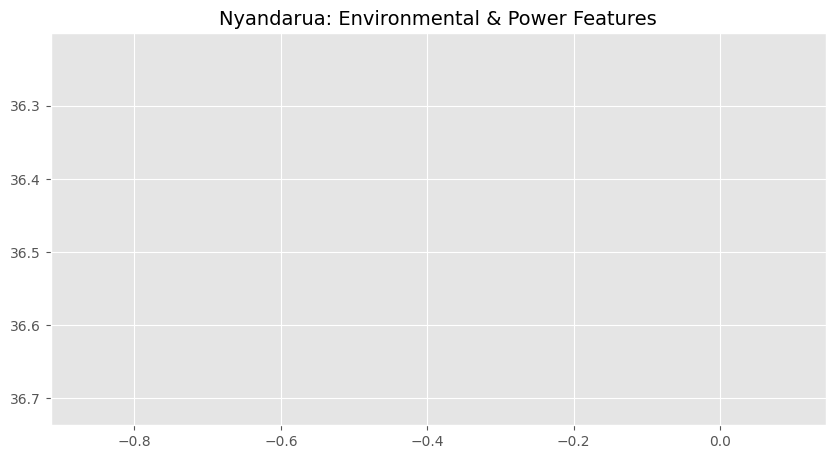

bbox (36.604038238000044, -0.640764653999895, 37.30781026700009, 0.020351303000040843)


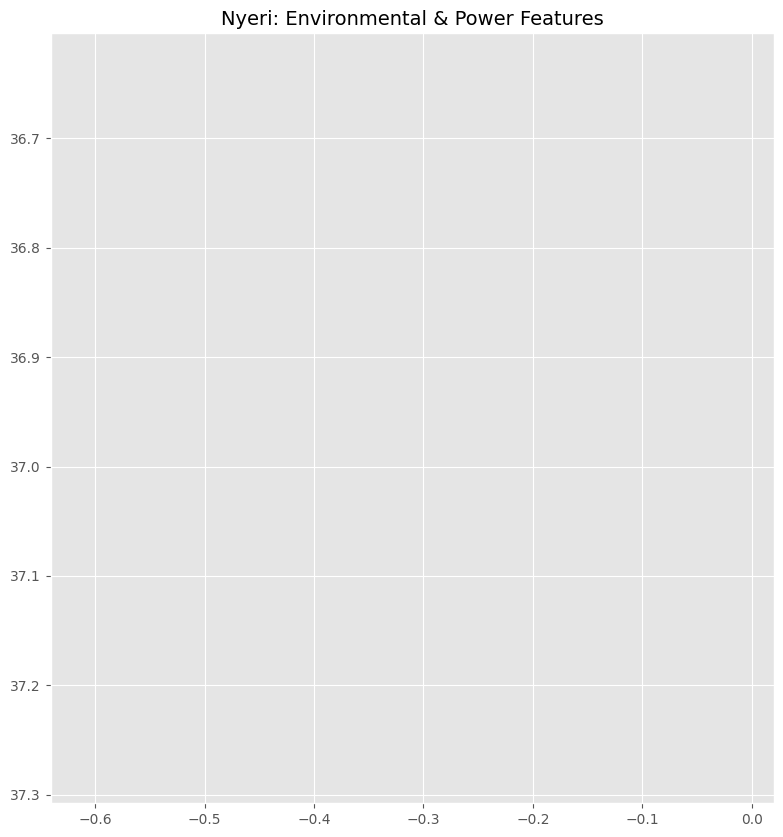

bbox (36.28931427000015, 0.5706711410001617, 38.07994079500014, 2.5158431530001053)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 17 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


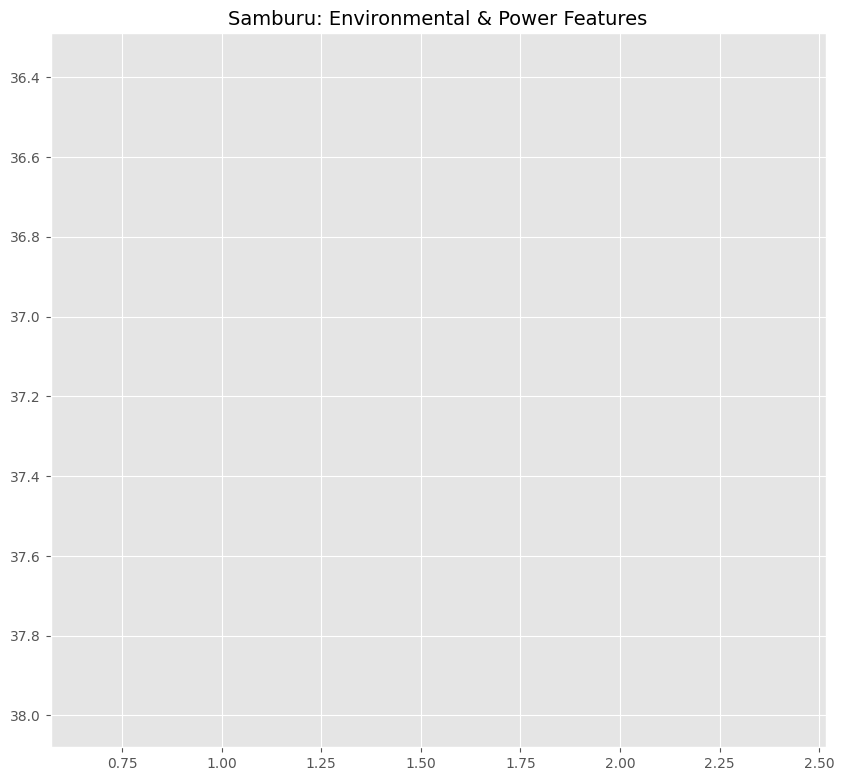

bbox (33.949901888000056, -0.4243917459999693, 34.560173034000115, 0.31758764400007067)


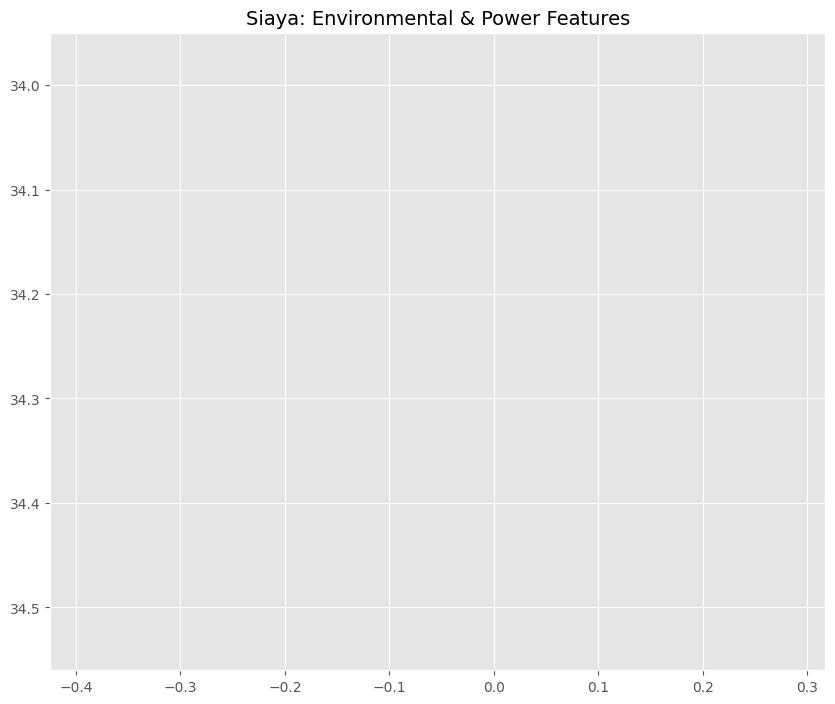

bbox (37.58544921900017, -4.13878869999985, 39.21990966800013, -2.6791992179998942)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 11 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


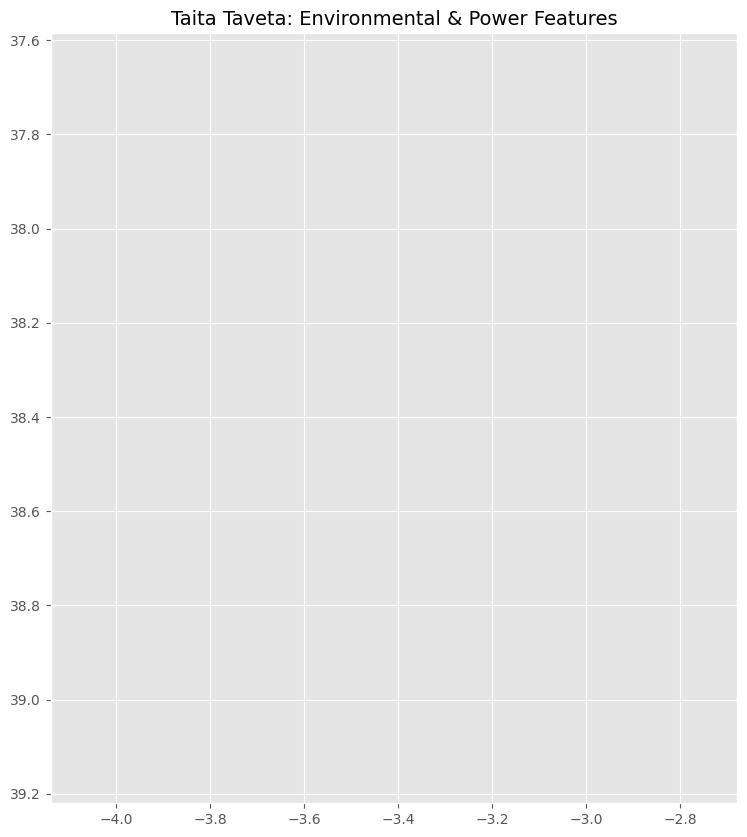

bbox (38.417114258000026, -3.068576999999948, 40.737361908000025, -0.0015258789998711109)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 34 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


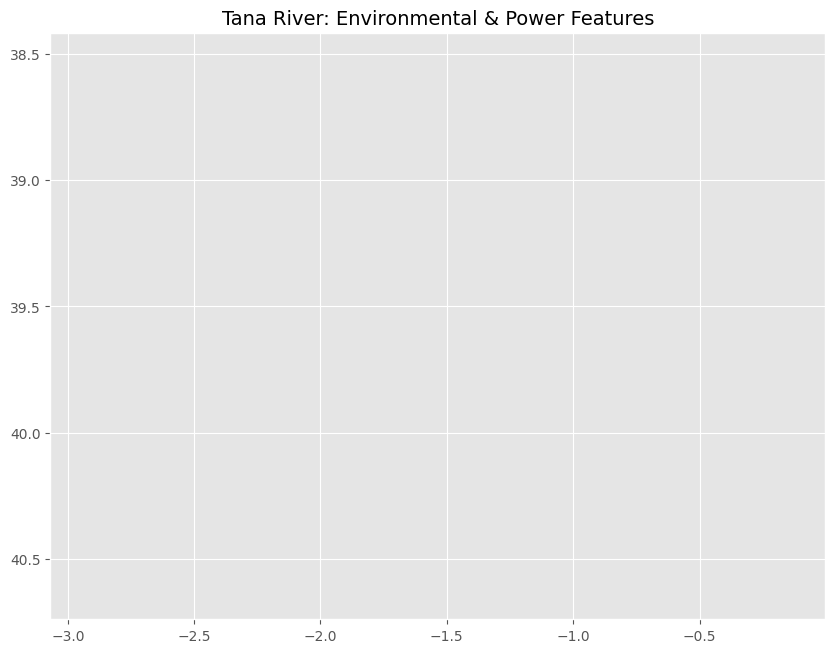

bbox (37.3128334000001, -0.4511108399999557, 38.30847167900009, 0.06768800000008923)


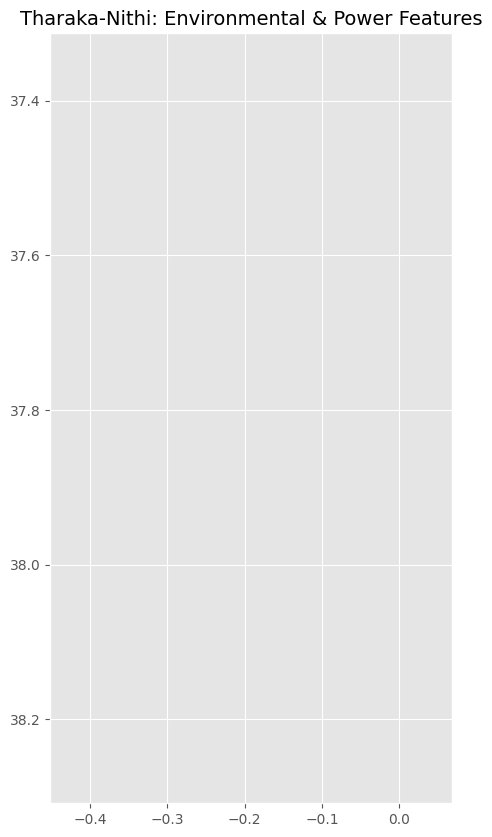

bbox (34.58178710900012, 0.8112256540001113, 35.36264038000007, 1.2837642440001673)


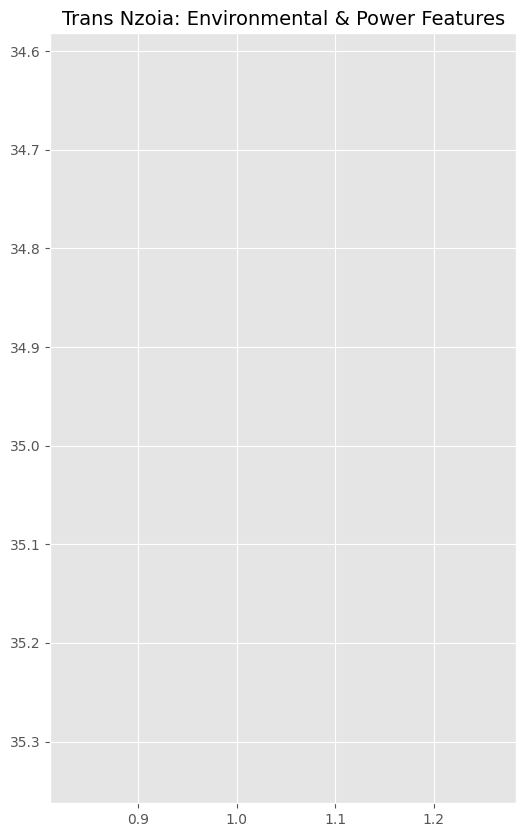

bbox (33.99208831900012, 0.9162899250001146, 36.72388839700005, 5.061165809999977)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 55 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


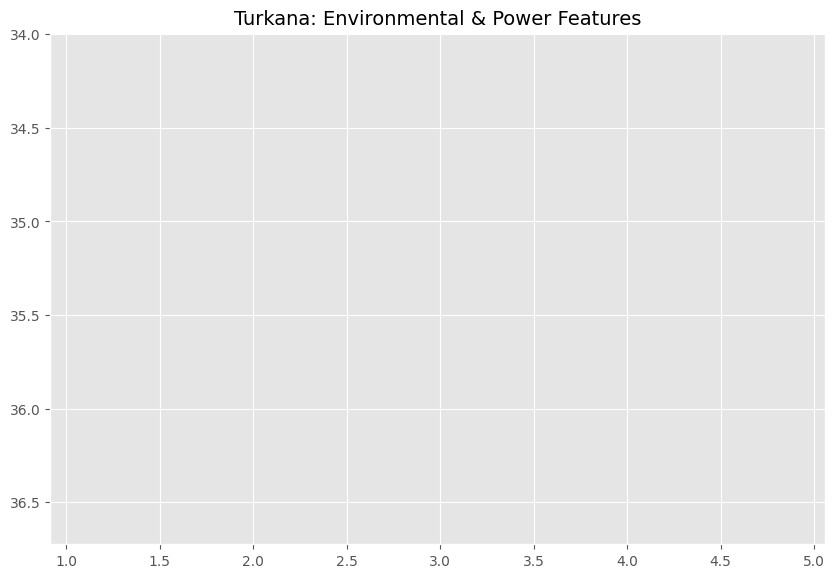

bbox (34.85208129800009, 0.012717474000169204, 35.59074020300011, 0.9502371550001385)


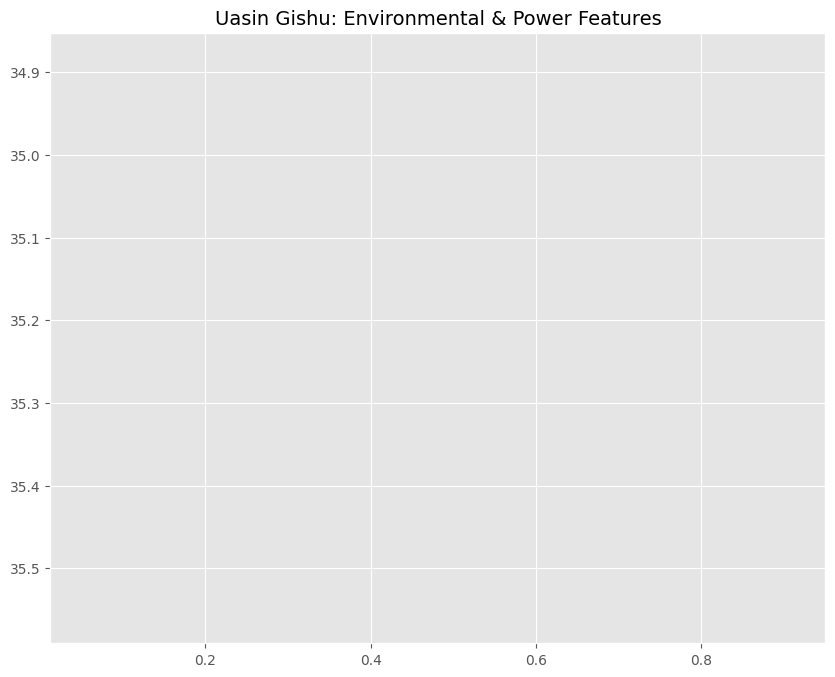

bbox (34.533020019000105, -0.03623918099987122, 34.92058563300009, 0.21260425400009808)


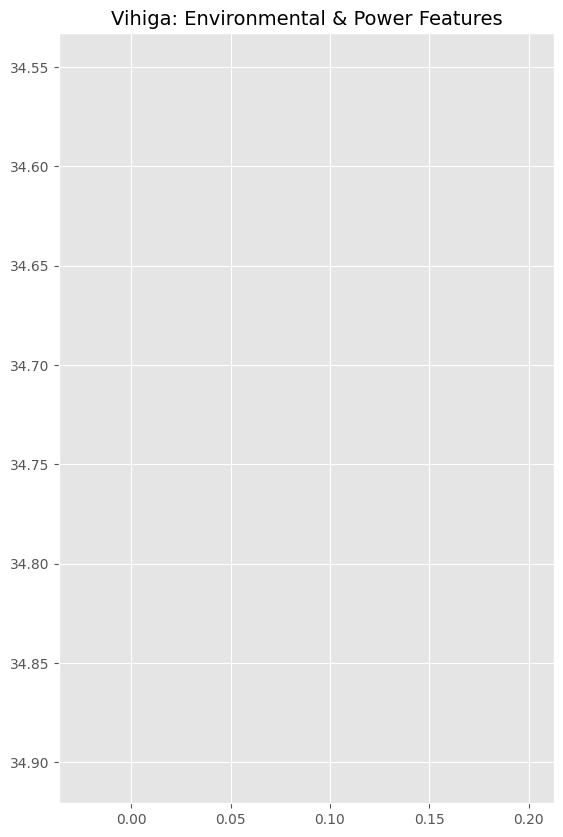

bbox (38.88812255900001, 0.18347168000002512, 40.99470901400019, 3.686499357000173)


/usr/local/lib/python3.12/dist-packages/osmnx/_overpass.py:271: UserWarning: This area is 36 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


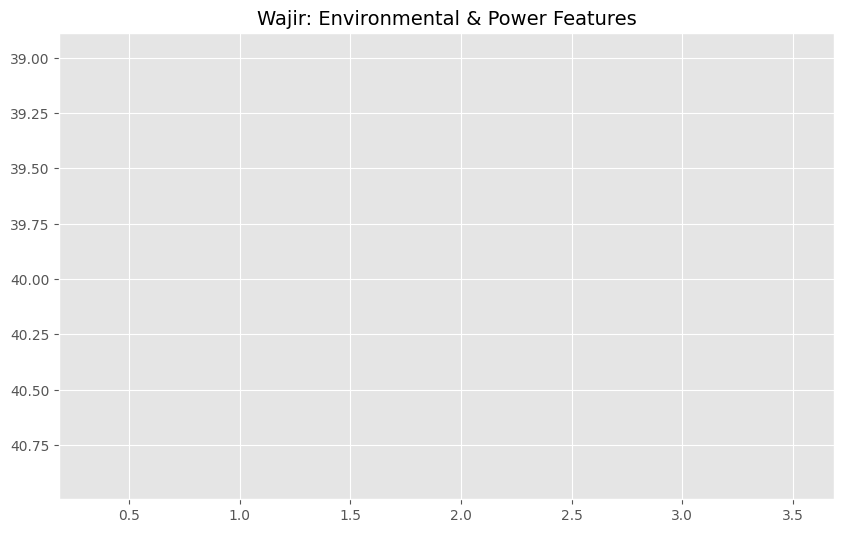

bbox (34.786674500000174, 0.9844281680000222, 35.790542603000176, 2.652702569000155)


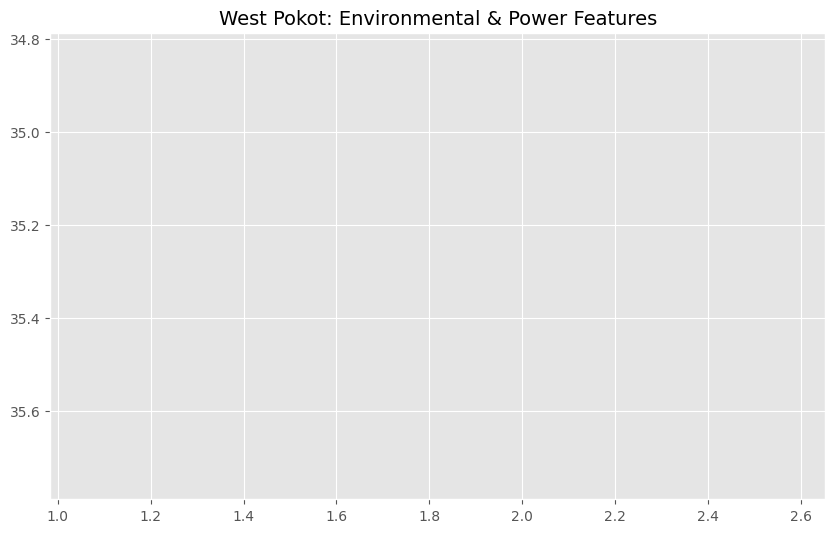

In [28]:
# Define tags for environmental features potentially impacted by power stations
tags = {
    "waterway": ["river", "dam"],
    "natural": ["water", "lake", "reservoir"],
    "landuse": ["forest"],
    "power": ["tower", "substation"],
    "boundary": ["protected_area", "national_park"]
}

# This will call the function and save the queried features to CSV files
fynesse.access.plot_osm_features_by_county(kenya_counties, tags, save_csv=True)

## **3. Clipping and Combining Features**

**Clipping and Filtering:**
   - The boundary of Kenya is prepared by dissolving the county geometries, and the combined POIs are clipped to this boundary to focus only on features within Kenya.
   - The clipped GeoDataFrame is filtered to extract different types of features, such as rivers, water bodies, and forests.


/content/mlfc_mini-project/fynesse/assess.py:140: DtypeWarning: Columns (7,8,11,12,13,14,16,19,22,23,24,25,26,27,29,30,33,34,35,36,37,38,39,40,41,42,43,44,45,47,51,54,55,56,57,58,59,60,62,63,67,68,69,70,71,72,73,74,77,78,79,80,84,85,87,88,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,110,111,113,114,115,117,118,120,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  pois_df = pd.read_csv(csv_file)
/content/mlfc_mini-project/fynesse/assess.py:140: DtypeWarning: Columns (7,9,10,11,13,14,15,16,17,18,19,21,22,23,32,35,36,37,40,41,42,44,45,49,50,51,52,53,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81) have mixed types. Specify dtype option on import or set low_memory=False.
  pois_df = pd.read_csv(csv_file)
/content/mlfc_mini-project/fynesse/assess.py:178: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.ht

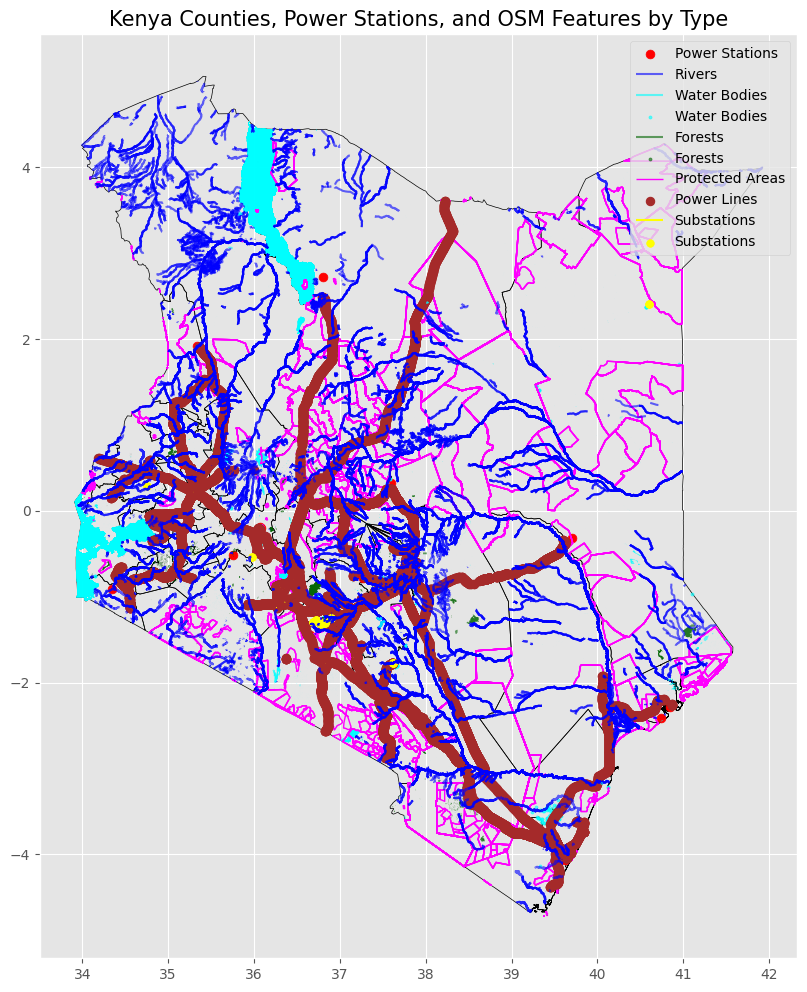

In [28]:
fynesse.assess.plot_features_with_clipping(
    kenya_counties,
    power_stations,
    "/content/drive/MyDrive/mlfc_miniproject/final_mlfc/county_pois_csv",
    tags
)


After downloading the OSM features, we combine and clean them. First, we **clip** the combined set of all POIs to Kenya’s boundary. We read all the CSV files created in the previous step and concatenate them into one large DataFrame. Each CSV row includes a WKT geometry string for the feature location. We then convert these WKT strings into actual geometry objects and create a GeoDataFrame

Next, we clip these features to Kenya’s outer boundary. We dissolve the county polygons into a single Kenya boundary and use ```gpd.clip``` to keep only those points inside Kenya. This ensures no features from outside Kenya are included:

Finally, we save the clipped features to a GeoJSON file for future use. This prevents rerunning the entire OSM fetch and clip later:

In [34]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import warnings, os

# Load and combine CSVs
path = "/content/drive/MyDrive/mlfc_miniproject/final_mlfc/county_pois_csv"
dfs = []
for file in os.listdir(path):
    if file.endswith(".csv"):
        try:
            # Specify dtype for columns with mixed types to avoid DtypeWarning
            # Or, handle warnings by specifying low_memory=False
            df = pd.read_csv(os.path.join(path, file), low_memory=False)
            dfs.append(df)
        except Exception as e:
            warnings.warn(f"Could not read {file}: {e}")

combined_pois = pd.concat(dfs, ignore_index=True)

# Convert 'geometry' column from WKT strings to geometry objects
# Handle potential NaNs in the geometry column
combined_pois['geometry'] = combined_pois['geometry'].apply(
    lambda geom_str: wkt.loads(geom_str) if pd.notna(geom_str) else None
)

# Convert to GeoDataFrame using the 'geometry' column
gdf = gpd.GeoDataFrame(
    combined_pois,
    geometry='geometry', # Specify the geometry column name
    crs="EPSG:4326"
)

# Load counties
kenya_counties = gpd.read_file("/content/drive/MyDrive/mlfc_miniproject/gadm41_KEN/gadm41_KEN_1.shp")
kenya_counties = kenya_counties.to_crs(gdf.crs)

# Clip
combined_pois_clipped = gpd.clip(gdf, kenya_counties)
print("Clipped POIs:", combined_pois_clipped.shape)

# Save for reuse
out_file = "/content/drive/MyDrive/mlfc_miniproject/final_mlfc/combined_pois_clipped.geojson"
combined_pois_clipped.to_file(out_file, driver="GeoJSON")
print(f"Saved clipped POIs to {out_file}")

Clipped POIs: (100285, 279)
Saved clipped POIs to /content/drive/MyDrive/mlfc_miniproject/final_mlfc/combined_pois_clipped.geojson


## **4. County-Level Visualization**

In [29]:
import geopandas as gpd
combined_pois_clipped = gpd.read_file(
    "/content/drive/MyDrive/mlfc_miniproject/final_mlfc/combined_pois_clipped.geojson"
)


To verify our data and for exploratory analysis, we plot these features (and power stations) for a specific county. The notebook defines a function (commented out) called ```plot_county_features``` that filters the GeoDataFrames by county and plots each feature category with distinct colors.

As an example, we select **Kiambu** County:(*Change to any county to visualize*)

/content/mlfc_mini-project/fynesse/assess.py:242: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


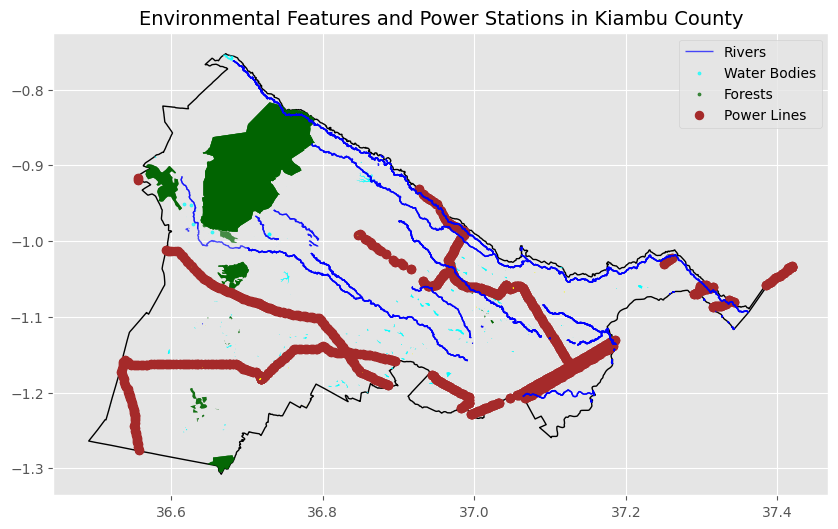

,element,id,power,material,operator,funded_by,image:pointofinterest,name,natural,operational_status,...,line_arrangement,source:position,source:tracer,source:zoomlevel,left:region,right:region,source:geometry,site_status,river,geometry
14465,way,3.908796e+07,None,None,None,None,None,Athi River,None,None,...,None,None,None,None,None,None,None,None,None,"MULTILINESTRING ((37.1573 -1.1997, 37.15709 -1..."
14453,way,3.908796e+07,None,None,None,None,None,Athi River,None,None,...,None,None,None,None,None,None,None,None,None,"MULTILINESTRING ((37.1573 -1.1997, 37.15709 -1..."
14456,way,3.908796e+07,None,None,None,None,None,Athi River,None,None,...,None,None,None,None,None,None,None,None,None,"MULTILINESTRING ((37.1573 -1.1997, 37.15709 -1..."
14458,way,3.908796e+07,None,None,None,None,None,Athi River,None,None,...,None,None,None,None,None,None,None,None,None,"MULTILINESTRING ((37.1573 -1.1997, 37.15709 -1..."
14467,way,3.908796e+07,None,None,None,None,None,Athi River,None,None,...,None,None,None,None,None,None,None,None,None,"MULTILINESTRING ((37.1573 -1.1997, 37.15709 -1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30649,node,1.287090e+10,tower,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (36.92668 -0.93076)
32093,node,7.765754e+09,tower,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (36.55601 -0.91916)
32092,node,7.765754e+09,tower,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (36.55601 -0.91916)
32094,node,7.765754e+09,tower,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (36.55569 -0.91674)


In [30]:
# Load counties
kenya_counties = gpd.read_file("/content/drive/MyDrive/mlfc_miniproject/gadm41_KEN/gadm41_KEN_1.shp")

# Load power stations shapefile into a GeoDataFrame
power_stations_gdf = gpd.read_file('/content/drive/MyDrive/mlfc_miniproject/final_mlfc/Power Stations/Power_Stations.shp')


# Define tags for environmental features potentially impacted by power stations
tags = {
    "waterway": ["river", "dam"],
    "natural": ["water", "lake", "reservoir"],
    "landuse": ["forest"],
    "power": ["tower", "substation"],
    "boundary": ["protected_area", "national_park"]
}

fynesse.assess.plot_county_features(
    "Kiambu",
    kenya_counties,
    combined_pois_clipped,
    power_stations_gdf,  # Pass the GeoDataFrame
    tags
)

This generates a map where rivers, lakes, forests, roads, and other features are layered for Kiambu, along with the red points marking power stations (see the notebook for the plotted image). The legend helps distinguish categories (e.g., blue for rivers, green for forests, orange for roads, red dots for stations).

## **5. Computing Distances to Features**

**Calculating the Distance of Power Stations to OSM Features**

This analysis examines the distance of power stations to rivers and lakes, which may reveal spatial gaps indicating that their locations were influenced by nearby water bodies supporting power generation. I will explore how power stations interact with OpenStreetMap (OSM) features and demonstrate how the placement of county power stations is influenced by these geographical features.

To conduct this analysis, We analyze how close each power station is to various environmental features. First, the code computes distances from each station to the nearest river, lake, forest, etc

Additionally, a distance-based sorting method will be employed to organize power stations by their proximity to water bodies, which will help identify patterns of environmental influence on their locations.

In [31]:
#path to power stations shapefile
power_stations_path='/content/drive/MyDrive/mlfc_miniproject/final_mlfc/Power Stations/Power_Stations.shp'

#load power stations shapefile
power_stations_gdf=gpd.read_file(power_stations_path)

# Ensure same CRS as counties
# Assuming kenya_counties is already loaded and has a CRS
if 'kenya_counties' in locals() and kenya_counties.crs is not None:
    power_stations_gdf = power_stations_gdf.to_crs(kenya_counties.crs)
else:
    # If kenya_counties is not available or has no CRS, default to a common CRS or handle as appropriate
    # For now, let's assume WGS84 if kenya_counties is not available
    if power_stations_gdf.crs is None:
        power_stations_gdf = power_stations_gdf.set_crs(epsg=4326)
    else:
        power_stations_gdf = power_stations_gdf.to_crs(epsg=4326)
    print("Warning: kenya_counties not available or CRS not set. Defaulting power_stations_gdf CRS to EPSG:4326.")

# --- Example Usage ---

if not combined_pois_clipped.empty:
    features = {
        "river": combined_pois_clipped[combined_pois_clipped['waterway'] == 'river'].copy(),
        "water_body": combined_pois_clipped[combined_pois_clipped['natural'] == 'water'].copy(),
        "forest": combined_pois_clipped[combined_pois_clipped['landuse'] == 'forest'].copy(),
        "substation": combined_pois_clipped[combined_pois_clipped['power'] == 'substation'].copy(),
        "protected": combined_pois_clipped[combined_pois_clipped['boundary'].notna()].copy(),
    }
else:
    features = {
        "river": gpd.GeoDataFrame(geometry=[], crs=power_stations_gdf.crs if power_stations_gdf.crs else "EPSG:4326"),
        "water_body": gpd.GeoDataFrame(geometry=[], crs=power_stations_gdf.crs if power_stations_gdf.crs else "EPSG:4326"),
        "forest": gpd.GeoDataFrame(geometry=[], crs=power_stations_gdf.crs if power_stations_gdf.crs else "EPSG:4326"),
        "substation": gpd.GeoDataFrame(geometry=[], crs=power_stations_gdf.crs if power_stations_gdf.crs else "EPSG:4326"),
        "protected": gpd.GeoDataFrame(geometry=[], crs=power_stations_gdf.crs if power_stations_gdf.crs else "EPSG:4326"),
    }

# Run calculation
# Ensure features dictionary is correctly populated and GeoDataFrames are valid
if all(not feature_gdf.empty for feature_gdf in features.values()):
  power_stations_with_distances = fynesse.assess.calculate_distances_to_features(power_stations_gdf, features, target_crs=32637)

  # Display results with new distance columns
  display(
      power_stations_with_distances[
          ["Name", "Type", "Capacity_M"] + [col for col in power_stations_with_distances.columns if col.startswith("distance_to_")]
      ].head()
  )
  #Save the csv for distance_features.csv to my drive
  output_csv_path = "/content/drive/MyDrive/mlfc_miniproject/final_mlfc/distance_features.csv"
  power_stations_with_distances.to_csv(output_csv_path, index=False)
else:
    print("Skipping distance calculation: One or more feature GeoDataFrames are empty.")
    # Initialize power_stations_with_distances with distance columns filled with None or NaN
    distance_cols = [f"distance_to_{key}" for key in features.keys()]
    for col in distance_cols:
        power_stations_gdf[col] = np.nan
    power_stations_with_distances = power_stations_gdf.copy()

    # Save the csv even if distance calculation was skipped, columns will have NaN
    output_csv_path = "/content/drive/MyDrive/mlfc_miniproject/final_mlfc/distance_features.csv"
    power_stations_with_distances.to_csv(output_csv_path, index=False)

,Name,Type,Capacity_M,distance_to_river,distance_to_water_body,distance_to_forest,distance_to_substation,distance_to_protected
0,Olkaria I Geothermal Power Station,Geothermal,185.0,9181.081065,118.270069,7860.775571,0.000000,0.0
1,Olkaria II Geothermal Power Station,Geothermal,105.0,9640.215961,3201.762120,5541.068380,134.628135,0.0
2,Olkaria III Geothermal Power Station,Geothermal,110.0,9004.596026,2289.455523,6515.921154,1085.252261,0.0
3,Olkaria IV Geothermal Power Station,Geothermal,140.0,9640.215961,3201.762120,5541.068380,134.628135,0.0
4,Olkaria V Geothermal Power Station,Geothermal,140.0,9640.215961,3201.762120,5541.068380,134.628135,0.0


**Calculating Density per County and per Square Kilometer**

## 🔍 Function: Compute Power Station Density by County

This function analyzes the spatial distribution of power stations across Kenyan counties and computes their density per square kilometer.
- Aligns coordinate reference systems (CRS) for spatial accuracy.

- Performs a spatial join to associate power stations with counties.

- Computes county areas using UTM projection.

- Calculates and displays power station density per square kilometer.


In [49]:
fynesse.assess.compute_power_station_density(power_stations_gdf, kenya_counties)


,NAME_1,power_station_count,area_sqkm,density_per_sqkm
11,Mombasa,5,267.163380,0.018715
13,Nairobi,2,712.712348,0.002806
14,Nakuru,11,7489.235662,0.001469
12,Murang'a,3,2527.097912,0.001187
0,Embu,2,2903.910969,0.000689
7,Machakos,3,6034.178286,0.000497
4,Kiambu,1,2575.452993,0.000388
5,Kisumu,1,2676.946867,0.000374
10,Migori,1,3219.035465,0.000311
15,Nyeri,1,3336.249666,0.000300


**Cluster power stations using DBSCAN**

In [50]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

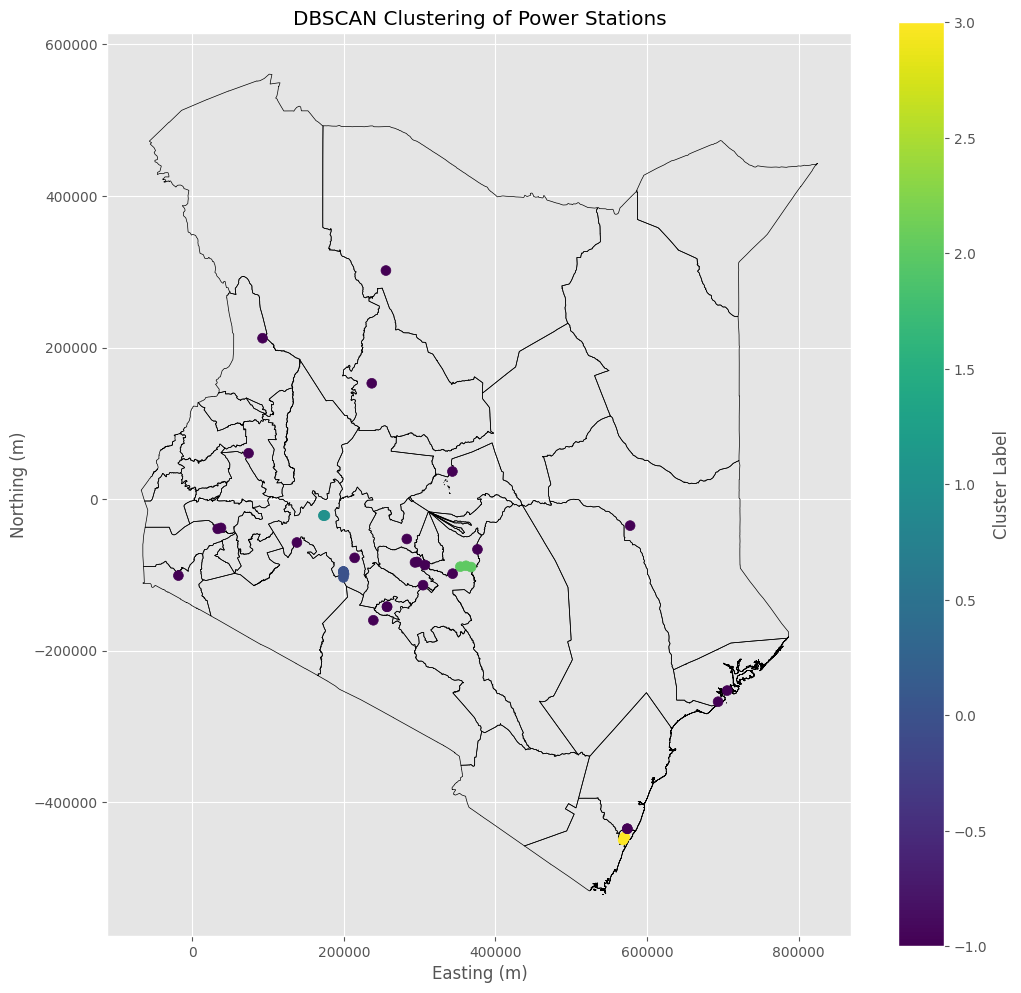

,Name,Type,Capacity_M,cluster_label
0,Olkaria I Geothermal Power Station,Geothermal,185.0,0
1,Olkaria II Geothermal Power Station,Geothermal,105.0,0
2,Olkaria III Geothermal Power Station,Geothermal,110.0,0
3,Olkaria IV Geothermal Power Station,Geothermal,140.0,0
4,Olkaria V Geothermal Power Station,Geothermal,140.0,0


cluster_label
-1    25
 0     6
 1     3
 2     3
 3     3
Name: count, dtype: int64


In [55]:
# Project power stations to the same CRS for area calculation
power_stations_proj = power_stations_gdf.to_crs(epsg=32637)

# Ensure kenya_counties is in a projected CRS for accurate area calculation
kenya_counties_proj = kenya_counties.to_crs(epsg=32637)  # Using UTM Zone 37N

# Run DBSCAN on power stations
clustered_power, counts = fynesse.assess.run_dbscan_clustering(
    power_stations_proj,
    eps=10000,
    min_samples=3,
    counties_gdf=kenya_counties_proj,
    plot=True
)

display(clustered_power[['Name', 'Type', 'Capacity_M', 'cluster_label']].head())
print(counts)

#Save the DBSCAN clustered_power


## 🔍 DBSCAN Clustering of Power Stations

We apply DBSCAN clustering to spatially group Kenya's power stations based on proximity and density.
- ```eps=10000``` defines the maximum distance (in meters) between points to be considered neighbors.

- ```min_samples=3``` sets the minimum number of stations required to form a cluster.

In [56]:
clustered_power = fynesse.assess.run_dbscan_with_features(power_stations_proj, eps=10000, min_samples=3)

display(clustered_power[['Name', 'Type', 'Capacity_M', 'cluster_label',
                         'cluster_size', 'dist_to_cluster_centroid']].head())
#save a dbscan_cluster csv
output_csv_path = "/content/drive/MyDrive/mlfc_miniproject/final_mlfc/dbscan_cluster.csv"
clustered_power.to_csv(output_csv_path, index=False)

,Name,Type,Capacity_M,cluster_label,cluster_size,dist_to_cluster_centroid
0,Olkaria I Geothermal Power Station,Geothermal,185.0,0,6,1465.583902
1,Olkaria II Geothermal Power Station,Geothermal,105.0,0,6,2049.870127
2,Olkaria III Geothermal Power Station,Geothermal,110.0,0,6,798.924206
3,Olkaria IV Geothermal Power Station,Geothermal,140.0,0,6,2049.870127
4,Olkaria V Geothermal Power Station,Geothermal,140.0,0,6,2049.870127


We perform a DBSCAN clustering of the power stations themselves, saving cluster labels in dbscan_cluster.csv. To prepare for modeling, we merge these two CSVs into a single dataset using the station's OBJECTID as the key

In [57]:
import pandas as pd

# Load both files
df_features = pd.read_csv("/content/drive/MyDrive/mlfc_miniproject/final_mlfc/distance_features.csv")
df_clusters = pd.read_csv("/content/drive/MyDrive/mlfc_miniproject/final_mlfc/dbscan_cluster.csv")

merged_df = pd.merge(df_features, df_clusters, on="OBJECTID", how="left")
#save a csv
merged_df.to_csv("/content/drive/MyDrive/mlfc_miniproject/final_mlfc/merged_df.csv", index=False)

At this point, ```merged_df.csv``` contains all computed features (distances to OSM features and any cluster info) for each known power station. We will use this as our training data.

### Gaussian Process Model - Training and Prediction

This section focuses on building and training a Gaussian Process (GP) model to predict the probability of finding a power station at any given location within Kenya, based on the associated environmental features. We will use the `scikit-learn` library for implementing the Gaussian Process Classifier.

**Steps:**
1. Prepare the data for the GP model.
2. Define and configure the Gaussian Process Classifier.
3. Train the model using the grid data.
4. Predict the probability of power station presence across the grid.
5. Visualize the prediction results.

We now load the enriched dataset of features for modeling. We fill any missing values (NaNs) with zeros to avoid issues in training, and we define the target label. Since we only have positive examples (actual station locations), we set the label to 1 for all these rows (indicating a station is present). The feature columns are a list of distance metrics (e.g., ```distance_to_river```, ```distance_to_forest```, etc.) along with clustering features:

In [59]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

# Load your enriched dataset containing all calculated features
# This should be the CSV saved in cell nA4MdMvXq9wl
csv_path = "/content/drive/MyDrive/mlfc_miniproject/final_mlfc/merged_df.csv"

try:
    df = pd.read_csv(csv_path)

    # Define feature columns - ensure these match the columns saved in the CSV
    # Based on the output of cell nA4MdMvXq9wl, these columns should be available
    feature_cols = [
        'distance_to_river_x',
        'distance_to_water_body_x',
        'distance_to_forest_x',
        'distance_to_substation_x',
        'distance_to_protected_x',
        'cluster_label',
        'cluster_size',
        'dist_to_cluster_centroid'
    ]

    # Fill missing values. It's important to handle NaNs appropriately for the model.
    # Filling with 0 is a simple approach, but consider more sophisticated methods if needed.
    df.fillna(0, inplace=True)

    # Define the target variable (label). For the power stations themselves, the label is 1.
    df['label'] = 1  # For known stations

    # Define X (features) and y (target) for model training
    X = df[feature_cols]
    y = df['label']

    print("DataFrame 'df' loaded and prepared. Head:")
    display(df.head())
    print("\nFeature columns (X) shape:", X.shape)
    print("Target variable (y) shape:", y.shape)

except FileNotFoundError:
    print(f"Error: The file '{csv_path}' was not found. Please ensure cell nA4MdMvXq9wl was executed successfully.")
except KeyError as e:
    print(f"Error: One or more columns specified in feature_cols were not found in the DataFrame. Missing columns: {e}")
    print("Available columns in the DataFrame:", df.columns.tolist())
except Exception as e:
    print(f"An unexpected error occurred: {e}")

DataFrame 'df' loaded and prepared. Head:


,OBJECTID,Type_x,Name_x,Capacity_M_x,Coordinate_x,X_Coord_x,Y_Coord_x,Status_x,Year_x,Remarks_x,...,geometry_y,distance_to_river_y,distance_to_water_body_y,distance_to_forest_y,distance_to_substation_y,distance_to_protected_y,cluster_label,cluster_size,dist_to_cluster_centroid,label
0,1,Geothermal,Olkaria I Geothermal Power Station,185.0,0°53′36″S 36°18′30″E,36.308333,-0.893333,Operational,0,0,...,POINT (200410.14522662485 -98850.03216639161),9181.081065,118.270069,7860.775571,0.000000,0.0,0,6,1465.583902,1
1,2,Geothermal,Olkaria II Geothermal Power Station,105.0,0°51′49″S 36°18′00″E,36.300000,-0.863611,Operational,0,0,...,POINT (199479.55417638208 -95561.83328497596),9640.215961,3201.762120,5541.068380,134.628135,0.0,0,6,2049.870127,1
2,3,Geothermal,Olkaria III Geothermal Power Station,110.0,0°52′30″S 36°18′00″E,36.300000,-0.875000,Operational,0,0,...,POINT (199480.45585256565 -96822.05840125307),9004.596026,2289.455523,6515.921154,1085.252261,0.0,0,6,798.924206,1
3,4,Geothermal,Olkaria IV Geothermal Power Station,140.0,0°51′49″S 36°18′00″E,36.300000,-0.863611,Operational,0,0,...,POINT (199479.55417638208 -95561.83328497596),9640.215961,3201.762120,5541.068380,134.628135,0.0,0,6,2049.870127,1
4,5,Geothermal,Olkaria V Geothermal Power Station,140.0,0°51′49″S 36°18′00″E,36.300000,-0.863611,In development,0,0,...,POINT (199479.55417638208 -95561.83328497596),9640.215961,3201.762120,5541.068380,134.628135,0.0,0,6,2049.870127,1



Feature columns (X) shape: (40, 8)
Target variable (y) shape: (40,)


# 🌍 Function: Generate Spatial Grid Over Kenya

This function creates a regular grid of points across Kenya’s geographic boundary, useful for spatial modeling, interpolation, or environmental sampling.

### 🧠 What It Does
- Reprojects Kenya’s boundary to UTM Zone 37N for accurate metric spacing.
- Generates a grid of points spaced at `spacing_km` kilometers.
- Clips the grid to fit within Kenya’s actual boundary.
- Returns the grid in WGS84 (EPSG:4326) for compatibility with most GIS datasets.

In [ ]:
fynesse.address.generate_grid(kenya_counties, spacing_km=10)

## 📍 Function: Label Grid Points by Proximity to Power Stations

This function assigns a binary label to each grid point based on its proximity to known power stations in Kenya.

### 🧠 What It Does
- Reprojects both the grid and power station geometries to UTM Zone 37N for accurate distance calculations.
- Computes the minimum distance from each grid point to any power station.
- Labels the point as `1` if it's within `threshold_m` meters of a station, otherwise `0`.

In [ ]:
fynesse.address.label_grid_points(grid_gdf, power_stations_gdf, threshold_m=50000)

## 🌿 Function: Add Environmental Distance Features to Grid

This function enriches a spatial grid with proximity-based features by calculating the distance from each grid point to various environmental elements across Kenya.

### 🧠 What It Does
- Reprojects all input GeoDataFrames to UTM Zone 37N (EPSG:32637) for accurate metric-based distance calculations.
- Computes the minimum distance from each grid point to:
  - Rivers
  - Water bodies (lakes, reservoirs)
  - Forests
  - Substations (from power station data)
  - Protected areas (e.g., national )

  NB:*All distances are in meters*

In [ ]:
fynesse.address.add_environmental_features(grid_gdf, rivers_gdf, water_bodies_gdf, forests_gdf, power_stations_gdf, protected_areas_gdf)

## 🧠 Function: Prepare Data for Gaussian Process Model

This function extracts the feature matrix and target labels from a spatial grid GeoDataFrame for training a Gaussian Process Classifier.

In [ ]:
fynesse.address.prepare_gp_data(grid_with_features)

## ⚙️ Preparing Grid-Based Training Data for Gaussian Process Model

It checks for the availability of key input variables and prepares a spatial grid enriched with environmental features for machine learning.

In [ ]:
fynesse.address.prepare_gp_training_data(kenya_counties, power_stations_gdf, features, spacing_km=10, threshold_m=50000)

In [65]:
# Ensure necessary variables are available
if ('kenya_counties' in locals() and 'power_stations_gdf' in locals() and 'features' in locals()):

    kenya_boundary = kenya_counties.dissolve()
    grid = generate_grid(kenya_boundary)
    grid_labeled = label_grid_points(grid, power_stations_gdf)

    # Call add_environmental_features with the correct GeoDataFrames from the features dictionary
    # Ensure the keys exist in the features dictionary before accessing
    rivers_gdf = features.get("river", gpd.GeoDataFrame(geometry=[], crs=kenya_counties.crs))
    water_bodies_gdf = features.get("water_body", gpd.GeoDataFrame(geometry=[], crs=kenya_counties.crs))
    forests_gdf = features.get("forest", gpd.GeoDataFrame(geometry=[], crs=kenya_counties.crs))
    protected_areas_gdf = features.get("protected", gpd.GeoDataFrame(geometry=[], crs=kenya_counties.crs))


    grid_with_features = add_environmental_features(
        grid_labeled,
        rivers_gdf,
        water_bodies_gdf,
        forests_gdf,
        power_stations_gdf, # Pass power stations gdf
        protected_areas_gdf # Pass protected areas gdf
    )

    X, y = prepare_gp_data(grid_with_features)

else:
    print("Cannot prepare data: Required input variables are not available.")
    X = None
    y = None

KeyboardInterrupt: 

## 🔍 Inspecting Feature Matrix and Target Labels

This snippet displays the first few rows of the feature matrix `X` and the target variable `y`, which are used for training the Gaussian Process model.

In [60]:
# Display the first few rows of the feature matrix (X) and the target variable (y)

# Ensure X and y are available from the previous cell
if 'X' in locals() and 'y' in locals():
    print("First 5 rows of the feature matrix (X):")
    display(X[:5])
    print("\nFirst 5 values of the target variable (y):")
    display(y[:5])
else:
    print("X and y variables not found. Please run the previous cell to prepare the data.")

First 5 rows of the feature matrix (X):


array([[15513.0813842 ,     0.        , 21107.13682491, 39039.77606396,
        32429.09860723],
       [13486.94978954,     0.        , 13137.57424148, 40072.13675745,
        25833.28087865],
       [11922.91500826,     0.        ,  7497.90842315, 43444.77153226,
        21978.86178656],
       [16937.56654323,     0.        , 11481.08004434, 48673.60889305,
        22333.43524652],
       [25131.78104549,     0.        , 14475.32132152, 55233.97715045,
        26240.93030512]])


First 5 values of the target variable (y):


array([1, 1, 1, 1, 0])

## 🤖 Function: Train Gaussian Process Classifier

This function trains a Gaussian Process Classifier (GPC) using environmental and spatial features extracted from a grid over Kenya. It handles missing values, configures the model with an RBF kernel, and returns a trained classifier.
- Extracts features and labels from a GeoDataFrame.
- Imputes missing values using column-wise means.
- Configures a Gaussian Process Classifier with an RBF kernel.
- Trains the model.

In [ ]:
gpc_model = fynesse.address.train_gp_classifier(grid_with_features)


## 🔮 Predicting Power Station Presence Across Kenya

It uses a trained Gaussian Process Classifier to estimate the probability of power station presence at each grid point across

In [ ]:
grid_with_predictions = fynesse.address.predict_power_station_probability(gpc_model, X, grid_with_features)


## 🗺️ Function: Visualize Predicted Power Station Probability

This function generates a heatmap showing the predicted probability of power station presence across Kenya, using output from a trained Gaussian Process Classifier.

In [ ]:
import matplotlib.pyplot as plt

def visualize_power_station_probability(grid_with_features, power_stations_proj=None):
    """
    Visualizes the predicted probability of power station presence across Kenya.

    Parameters:
    - grid_with_features: GeoDataFrame with 'power_station_probability' column
    - power_stations_proj: (Optional) GeoDataFrame of actual power station locations in projected CRS
    """
    if 'power_station_probability' in grid_with_features.columns and not grid_with_features.empty:
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))

        # Plot the probability heatmap
        grid_with_features.plot(
            column='power_station_probability',
            ax=ax,
            legend=True,
            cmap='OrRd',
            legend_kwds={
                'label': "Probability of Power Station Presence",
                'orientation': "horizontal"
            }
        )

        # Overlay actual power station locations if provided
        if power_stations_proj is not None and not power_stations_proj.empty:
            power_stations_proj.plot(
                ax=ax,
                color='blue',
                markersize=10,
                label='Actual Power Stations'
            )

        plt.title('Predicted Probability of Power Station Presence in Kenya')
        plt.xlabel('Easting (meters)')
        plt.ylabel('Northing (meters)')
        plt.legend()
        plt.show()
    else:
        print("Predicted probability column not found or grid data is empty. Cannot visualize.")


In [ ]:
fynesse.address.visualize_power_station_probability(grid_with_features, power_stations_proj)


## 📈 ROC Curve: Evaluating Model Performance

This block visualizes the Receiver Operating Characteristic (ROC) curve to assess the performance of the Gaussian Process Classifier in predicting power station presence across Kenya.

### 🧠 What It Shows
- **True Positive Rate (TPR)** vs. **False Positive Rate (FPR)** across different thresholds.
- The diagonal dashed line represents a random classifier.
- The ROC curve shows how well the model separates the two classes.
- **AUC (Area Under Curve)** quantifies overall performance: 1.00 = perfect classification.

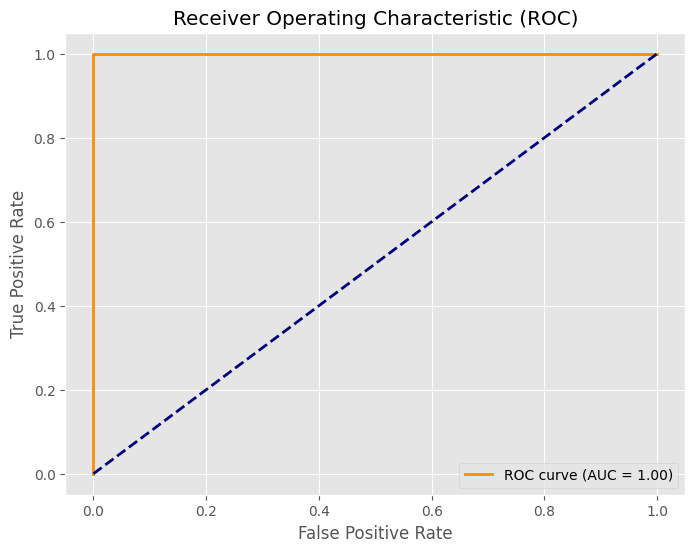

In [64]:
from sklearn.metrics import roc_curve, auc

y_true = grid_with_features['has_power_station']
y_scores = grid_with_features['power_station_probability']

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


The curve rises vertically from (0,0) to (0,1) and then moves horizontally to (1,1). This shape indicates that your classifier perfectly distinguishes between the two classes—every positive is correctly identified without any false positives.

The Area Under the Curve (AUC) is 1.00, which is the highest possible score. It means the model has 100% sensitivity and 100% specificity.

## 📊 Correlation Analysis: Environmental Features vs Power Station Presence

This block computes and visualizes the correlation between environmental distance features and the binary target variable `has_power_station`, helping to identify which spatial factors are most associated with power station locations.

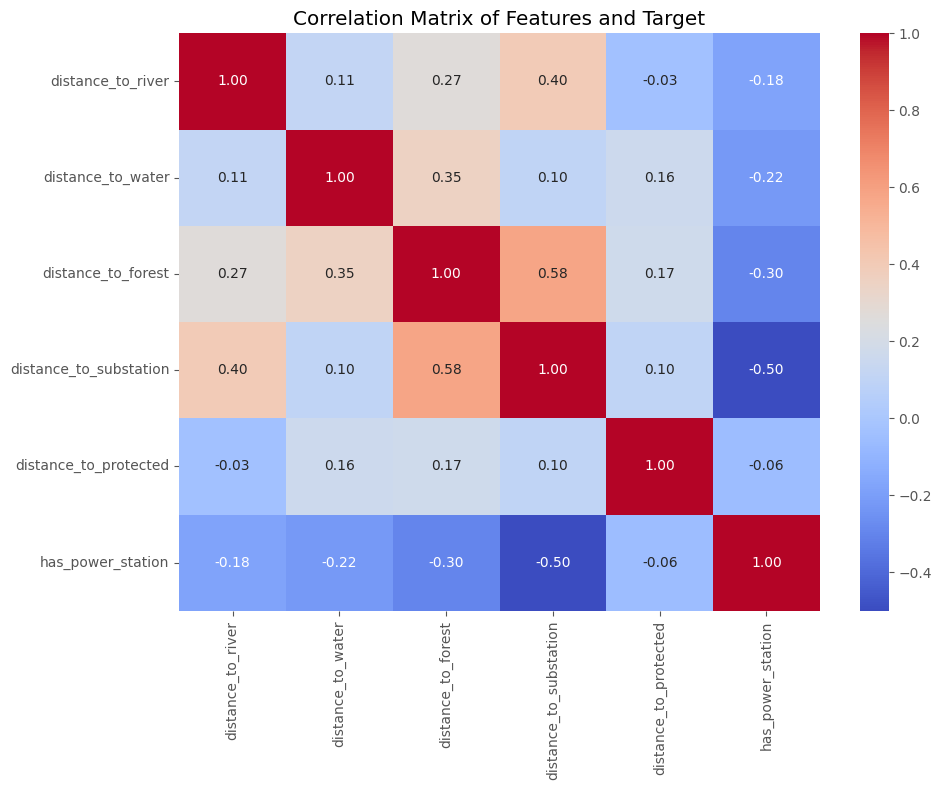

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure grid_with_features is available and contains the necessary columns
if 'grid_with_features' in locals() and not grid_with_features.empty:
    # Identify the distance feature columns and the target variable column
    feature_cols = [col for col in grid_with_features.columns if col.startswith('distance_to_')]
    all_cols_for_corr = feature_cols + ['has_power_station']

    # Ensure all required columns exist in the DataFrame
    if all(col in grid_with_features.columns for col in all_cols_for_corr):
        # Calculate the correlation matrix
        corr_matrix = grid_with_features[all_cols_for_corr].corr()

        # Plot the heatmap
        plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f") # Add formatting for annotations
        plt.title('Correlation Matrix of Features and Target')
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.show()
    else:
        missing_cols = [col for col in all_cols_for_corr if col not in grid_with_features.columns]
        print(f"Error: Required columns for correlation analysis are missing: {missing_cols}")
        print("Available columns in grid_with_features:", grid_with_features.columns.tolist())

else:
    print("Error: grid_with_features DataFrame not found or is empty. Cannot calculate correlation matrix.")

## 📊 Interpretation: Correlation Matrix of Environmental Features and Power Station Presence

This correlation matrix reveals how spatial proximity to various environmental features relates to the likelihood of a power station being present at a given location in Kenya.

### 🔍 Key Insights

- **Negative Correlations with `has_power_station`**:
  - `distance_to_protected`: **−0.060**
  - `distance_to_substation`: **−0.050**

  These strong negative correlations suggest that power stations tend to be located **closer** to protected areas and substations. This may reflect strategic infrastructure planning, regulatory zoning, or logistical convenience.

- **Moderate Positive Correlations Between Features**:
  - `distance_to_forest` vs `distance_to_protected`: **+0.17**
  - `distance_to_forest` vs `distance_to_substation`: **+0.58**

  These indicate that forests, protected areas, and substations are often spatially clustered. Their co-location could be due to land use patterns or environmental planning constraints.

- **Weaker Correlations**:
  - Features like `distance_to_river` and `distance_to_water` show **low correlation** with the target variable, suggesting that proximity to water bodies may not be a strong predictor of power station presence in this dataset.

### 🧠 Modeling Implications

- Features with stronger correlations (especially negative ones) are likely to be **more informative** for classification tasks.
- These insights can guide:
  - **Feature selection** for model training.
  - **Spatial clustering** or **interaction modeling**.
  - **Policy analysis** on infrastructure placement.

## **Summary**

**Key Findings on Point Relationships and Spatial Factors:**

**Distance to Features:** The analysis calculated how close power stations are to various environmental elements, providing quantitative measures of their spatial relationships.

**Influence of Features:** The correlation analysis (shown in the heatmap) revealed significant spatial relationships:
There is a strong negative correlation between distance_to_protected and has_power_station (-0.06), suggesting that power stations tend to be located closer to protected areas.

Similarly, there is a strong negative correlation between distance_to_substation and has_power_station (-0.050), indicating a tendency for power stations to be located closer to substations. This is likely due to infrastructure requirements and planning.

Features like distance to rivers and water bodies showed weaker correlations in this specific analysis, suggesting that for this dataset and model, proximity to these water features was not as strong a predictor as proximity to protected areas or substations.